# 1. 📦 Импорт библиотек

In [6]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import re
import joblib
from typing import Any, Dict, List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
from datetime import timedelta, datetime
import os
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, roc_auc_score, precision_recall_curve, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
import shap
from ipywidgets import widgets
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import display

from modules.create_df import kline_candles
from modules.Save_and_Load import load_model_with_threshold, save_model_with_threshold
from modules.all_kline_changes import add_target_column, annotate_longs_mod
from modules.graphs_and_tables import plot_ohlc_signals, plot_corr_by_distance, plot_correlation_matrix, plot_price_with_indicators, explain_model_mutual_info, explain_model_shap, plot_predict_signals, backtest_model,\
    evaluate_model_with_threshold, explain_model_permutation, show_class_balance
from modules.indicators import delta_ema, macd_cross, delta_atr, delta_ema_volume, macd, regression_slope_price, regression_slope_volume, delta_rsi, ema_above_price, ema_speed, rsi_speed, rsi_divergence,\
    tema_slope_change, ema_price_distance

# 2. 📥 Загрузка и разметка данных Загрузка и разметка данных

## Загрузка данных с Bybit

Функция **kline_candles** принимает на вход наименование токена **simbol**, таймфрейм **tf**, начало и конец периода для загрузки **start/end**\
На выходе выдает df с данными грфика **Date, Close, Open, Low, High, Volume.**\
Базовые отрезки для:
- обучающей выборки **start** ='2022-03-10 00:00', **end** ='2024-12-09 21:00'
- тестовой выборки **start** = '2024-12-11 00:00', **end** ='2025-07-11 00:00'

In [66]:
df = kline_candles(symbol='LINKUSDT', tf=1, start='2022-03-10 00:00', end='2022-03-12 00:00')
df_test = kline_candles(symbol='LINKUSDT', tf=1, start='2024-12-11 00:00', end='2024-12-12 00:00')

In [67]:
df.head(5)

Date    Open    High     Low   Close  Volume
0 2022-03-09 21:01:00  13.838  13.838  13.817  13.823  1386.0
1 2022-03-09 21:02:00  13.823  13.855  13.823  13.855   853.7
2 2022-03-09 21:03:00  13.855  13.855  13.849  13.855   154.0
3 2022-03-09 21:04:00  13.855  13.855  13.854  13.855   110.2
4 2022-03-09 21:05:00  13.855  13.905  13.855  13.881  2832.9

## Сохранение данных в .csv файл

In [289]:
df.to_csv("downloads/LINKUSDT_m1_train_raw_data.csv", index=False, compression='zstd')
df_test.to_csv("downloads/LINKUSDT_m1_test_raw_data.csv", index=False, compression='zstd')

In [182]:
df.to_csv("downloads/LINK_test_m1_base_features.csv", index=False, compression='zstd')
df_test.to_csv("downloads/LINK_train_m1_base_features.csv", index=False, compression='zstd')

## Загрузка df из .csv файла

In [596]:
df= pd.read_csv('downloads/LINKUSDT_m1_train_raw_data.csv', compression='zstd')
df_test = pd.read_csv('downloads/LINKUSDT_m1_test_raw_data.csv', compression='zstd')
df.head(3)

Open    High     Low   Close  Volume                 Date
0  13.838  13.838  13.817  13.823  1386.0  2022-03-09 21:01:00
1  13.823  13.855  13.823  13.855   853.7  2022-03-09 21:02:00
2  13.855  13.855  13.849  13.855   154.0  2022-03-09 21:03:00

In [7]:
df= pd.read_csv('downloads/LINKUSDT_m1_train_raw_data_annotate.csv', compression='zstd')
df_test = pd.read_csv('downloads/LINKUSDT_m1_test_raw_data_annotate.csv', compression='zstd')
df.head(3)

Open    High     Low   Close  Volume                 Date  buy_noised  \
0  13.838  13.838  13.817  13.823  1386.0  2022-03-09 21:01:00         0.0   
1  13.823  13.855  13.823  13.855   853.7  2022-03-09 21:02:00         0.0   
2  13.855  13.855  13.849  13.855   154.0  2022-03-09 21:03:00         0.0   

   sell_noised  buy  sell  buy_strong  sell_strong  
0          0.0  0.0   0.0         0.0          0.0  
1          0.0  0.0   0.0         0.0          0.0  
2          0.0  0.0   0.0         0.0          0.0

In [8]:
df= pd.read_csv('downloads/LINK_test_m1_base_features.csv', compression='zstd')
df_test = pd.read_csv('downloads/LINK_train_m1_base_features.csv', compression='zstd')
df.head(3)

Open    High     Low   Close  Volume                 Date  buy_noised  \
0  13.982  13.984  13.981  13.984    28.3  2022-03-10 00:40:00         0.0   
1  13.984  14.020  13.984  14.020    97.1  2022-03-10 00:41:00         0.0   
2  14.020  14.025  14.016  14.016   249.4  2022-03-10 00:42:00         0.0   

   sell_noised  buy  sell  ...  rsi21_speed_30  rsi21_accel_30  \
0          0.0  0.0   0.0  ...       -0.002200       -0.000017   
1          0.0  0.0   0.0  ...       -0.001180       -0.000004   
2          0.0  0.0   0.0  ...       -0.001969       -0.000015   

   bullish_rsi_div_p7_s1  bullish_rsi_div_p7_s3  bullish_rsi_div_p7_s5  \
0                      0                      1                      0   
1                      0                      0                      0   
2                      0                      0                      0   

   bullish_rsi_div_p7_s10  bullish_rsi_div_p14_s1  bullish_rsi_div_p14_s3  \
0                       1                       0                       1   
1                       1                       0                       0   
2                       0                       0                       0   

   bullish_rsi_div_p14_s5  bullish_rsi_div_p14_s10  
0                       0                        0  
1                       0                        1  
2                       0                        0  

[3 rows x 139 columns]

## Разметка данных

**Назначение:** Функция **annotate_longs_mod** идентифицирует и фильтрует точки входа (buy) и выхода (sell) на основе анализа локальных минимумов и максимумов ценового графика.\
Ключевые особенности:
- Поиск локальных экстремумов в скользящем окне
- Многоуровневая фильтрация сигналов

Параметры:
- **win_size** - размер окна для поиска экстремумов
- **min_margin** - минимальное движение внутри окна
- **min_price_distance** - минимальное расстояние в цене (в процентах) между сигналами
- **target_candles** — количество свечей для проверки достижения целевого движения

Возвращает: DataFrame с колонками:
- **buy_noised, sell_noised** — базовые шумные сигналы
- **buy, sell** — отфильтрованные сигналы (с проверкой роста/падения)
- **buy_strong, sell_strong** — сильные отфильтрованные сигналы (с дополнительной фильтрацией расстояния)

In [168]:
df = annotate_longs_mod(df, win_size=20, min_margin=0.003, min_price_distance=0.005, target_candles=15)
df_test = annotate_longs_mod(df_test, win_size=20, min_margin=0.003, min_price_distance=0.005, target_candles=15)

In [169]:
df.head(3)

Open    High     Low   Close  Volume                 Date  buy_noised  \
0  13.838  13.838  13.817  13.823  1386.0  2022-03-09 21:01:00         0.0   
1  13.823  13.855  13.823  13.855   853.7  2022-03-09 21:02:00         0.0   
2  13.855  13.855  13.849  13.855   154.0  2022-03-09 21:03:00         0.0   

   sell_noised  buy  sell  buy_strong  sell_strong  
0          0.0  0.0   0.0         0.0          0.0  
1          0.0  0.0   0.0         0.0          0.0  
2          0.0  0.0   0.0         0.0          0.0

Функция **plot_ohlc_signals** рисует график OHLC с подсветкой buy/sell сигналов и шумных сигналов
    
Аргументы:
- df с колонками *'Open','High','Low','Close','buy','sell','buy_noised','sell_noised'*
- **start_idx**: начальный индекс участка
- **end_idx**: конечный индекс участка

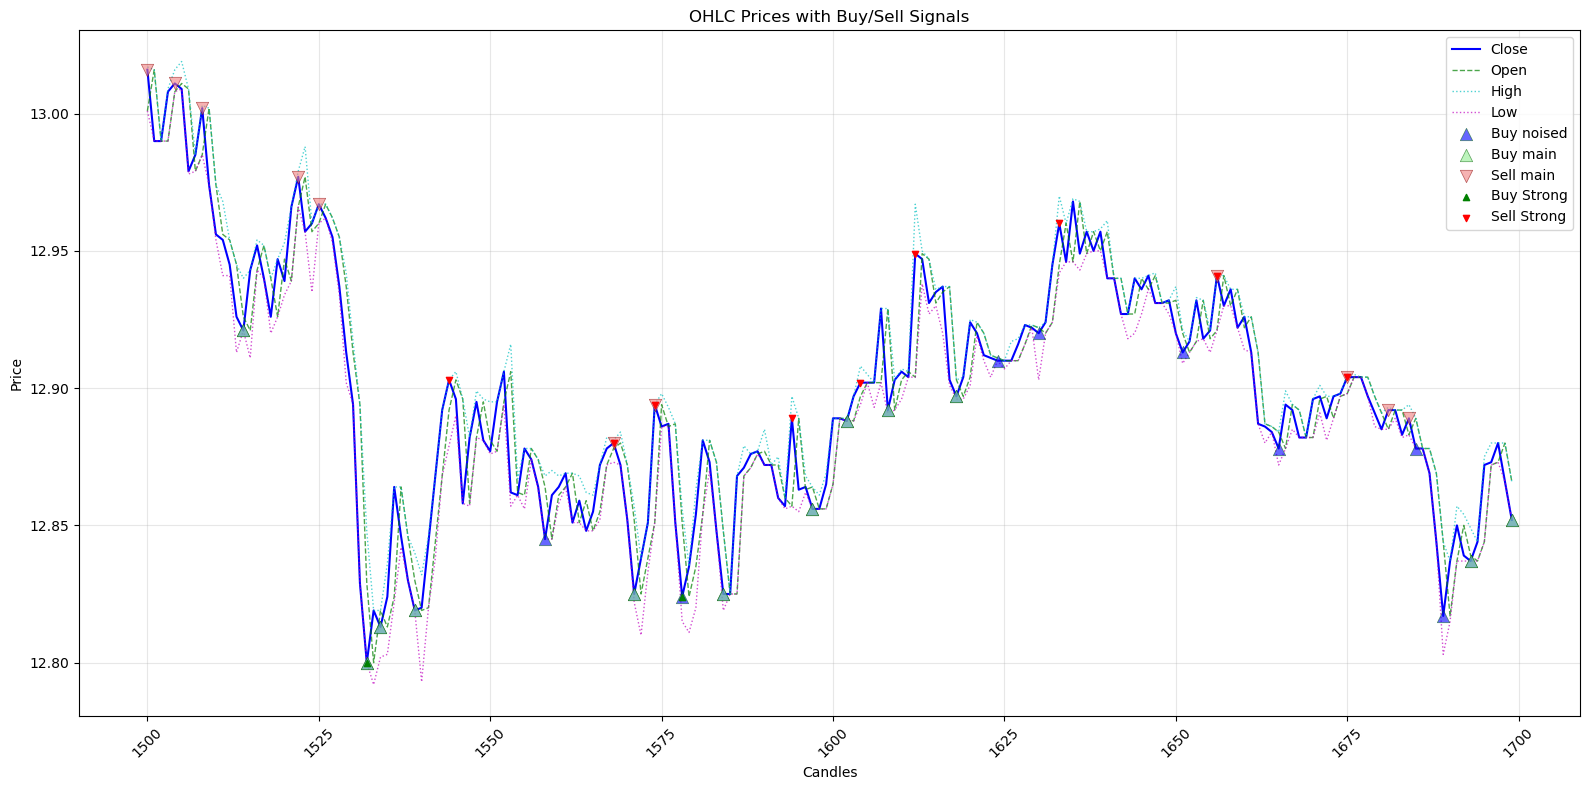

In [54]:
plot_ohlc_signals(df, 1500, 1700)

# 3. 📈 Добавление нормализованных индикаторов

## EMA

📌 Описание функции **delta_ema** *(df, ema_lengths=[20], window_size=20, num_blocks=4)*\
**Вход:**
- **df** — DataFrame с историческими свечами и обязательной колонкой Close.
- **ema_lengths** — список длин EMA, например [20, 50]
- **tema_lengths** — список длин TEMA, например
- **window_size** — общее кол-во свечей для анализа
- **num_blocks** — на сколько частей делим окно

**Что делает:**\
Для каждой EMA из списка **ema_lenghts**:

Считает относительное изменение EMA внутри каждого блока:
$$\frac{ema_{start} - ema_{end}}{ema_{start}}$$
Определяет, в скольких блоках EMA росла (значения в диапазоне 0–4 при стандартных настройках).\
**Выход:**\
Возвращает тот же df, но с добавленными колонками:\
block1_emaXX_rel_change, ..., block4_emaXX_rel_change — относительные изменения EMA для каждого блока.\
emaXX_grow_blocks — количество растущих блоков для данной EMA.

### delta_ema

In [9]:
df = delta_ema(df, ema_lengths=[20, 50, 200],tema_lengths=[9], window_size=20, num_blocks=4)
df_test = delta_ema(df_test, ema_lengths=[20, 50, 200],tema_lengths=[9], window_size=20, num_blocks=4)

### ema_above_price

Добавляет бинарные признаки, показывающие, находится ли EMA выше цены закрытия

In [12]:
df = ema_above_price(df, lengths=[20, 50, 100])
df_test = ema_above_price(df_test, lengths=[20, 50, 100])

### ema_speed

Добавляет признаки скорости и ускорения EMA с нормировкой.\
Входные данные:
- Периоды EMA для расчета (по умолчанию [20, 50])
- Окна для расчета скорости/ускорения (по умолчанию [10, 30, 60])

На выходе получаем первую и вторую производную ema

In [16]:
df = ema_speed(df, lengths=[9, 20, 50, 100], windows=[3, 10, 30, 60])
df_test = ema_speed(df_test, lengths=[9, 20, 50, 100], windows=[3, 10, 30, 60])

In [17]:
df.tail(1)

Open    High     Low   Close   Volume                 Date  \
1448639  22.367  22.416  22.285  22.378  61537.7  2024-12-09 21:00:00   

         buy_noised  sell_noised  buy  sell  ...  ema50_speed_60  \
1448639         0.0          0.0  0.0   0.0  ...       -0.000607   

         ema50_accel_60  ema100_speed_3  ema100_accel_3  ema100_speed_10  \
1448639   -3.949355e-07       -0.000761       -0.000001        -0.000697   

         ema100_accel_10  ema100_speed_30  ema100_accel_30  ema100_speed_60  \
1448639    -4.035286e-07        -0.000582    -4.469431e-07        -0.000428   

         ema100_accel_60  
1448639    -2.542767e-07  

[1 rows x 67 columns]

### ema_price_distance

**ema_price_distance** Добавляет относительное расстояние между EMA и ценой закрытия, а также динамику изменения этого расстояния.
    
Вход:
- df: DataFrame с колонкой 'Close'
- ema_periods: список периодов EMA
- norm_window: окно для нормализации (скользящее среднее цены)
- change_windows: список окон для расчета динамики изменения
    
Выход:
- Копия DataFrame с добавленными колонками:
* ema{period}_distance: относительное расстояние EMA от цены
* ema{period}_change_{window}: нормализованное изменение расстояния


In [21]:
df = ema_price_distance(df, ema_periods=[20, 50, 100], norm_window=200, change_windows=[3, 5, 10])
df_test = ema_price_distance(df_test, ema_periods=[20, 50, 100], norm_window=200, change_windows=[3, 5, 10])

### tema

Функция **tema_slope_change**.

Вход: DataFrame с колонкой 'Close', списки периодов TEMA **tema_periods** и окон расчета наклона **slope_windows**

Выход: Копия DataFrame с добавленными колонками нормализованных изменений наклона TEMA

In [27]:
df = tema_slope_change(df, tema_periods=[5, 10, 20], slope_windows=[3, 5, 8])
df_test = tema_slope_change(df_test, tema_periods=[5, 10, 20], slope_windows=[3, 5, 8])

## MACD

📌 Описание функции: **macd_cross** *(df, fast=12, slow=26, signal=9)*

Вход:
- **df** — DataFrame с колонкой Close (цены закрытия).
- **fast, slow, signal** — периоды MACD (по умолчанию 12, 26, 9).

Действие:
- Вычисляет MACD, сигнальную линию и гистограмму с помощью pandas_ta.
- Добавляет бинарный признак **macd_long_signal**:\
1 — если MACD выше сигнальной линии (лонговый режим).\
0 — если MACD ниже или равен сигнальной линии.

Выход:\
Исходный df с новым признаком:\
**macd_long_signal** (бинарный признак).

In [30]:
df = macd_cross(df)
df_test = macd_cross(df_test)

📌 **macd** добавляет базовые компоненты MACD, угол наклона гистограммы и признак лонгового пересечения за последние cross_lookback свечей.

Параметры:
- fast, slow, signal — стандартные параметры MACD
- slope_length — период для расчёта угла наклона гистограммы MACD
- cross_lookback — кол-во последних свечей, в которых ищется лонговое пересечение

In [32]:
df = macd(df, fast=12, slow=26, signal=9, cross_lookback=2)
df_test = macd(df_test, fast=12, slow=26, signal=9, cross_lookback=2)

## ATR

📌 Описание функции **delta_atr** *(df, atr_length=14, window_size=20, num_blocks=4)*\
Аналогичный расчет как для **delta_ema**, но для значений **ATR**

In [37]:
df = delta_atr(df, atr_length=14, window_size=10, num_blocks=2)
df_test = delta_atr(df_test, atr_length=14, window_size=10, num_blocks=2)

## Volume ema delta

📌 Описание функции **delta_ema_volume** *(df, ema_lenght=[20], block_size=5, shifts=None)*\
Аналогичный расчет как для **delta_ema**, но для значений **Volume**

In [40]:
df = delta_ema_volume(df, ema_lengths=[20], window_size=10, num_blocks=2)
df_test = delta_ema_volume(df_test, ema_lengths=[20], window_size=10, num_blocks=2)
df.tail(1)

Open    High     Low   Close   Volume                 Date  \
1448639  22.367  22.416  22.285  22.378  61537.7  2024-12-09 21:00:00   

         buy_noised  sell_noised  buy  sell  ...  macd_signal_12_26_9  \
1448639         0.0          0.0  0.0   0.0  ...            -0.164865   

         macd_hist_12_26_9  macd_hist_slope_12_26_9_5  \
1448639          -0.005121                  -0.000833   

         macd_long_signal_12_26_9_2  block1_atr14_rel_change  \
1448639                           0                  0.06103   

         block2_atr14_rel_change  atr14_grow_blocks  \
1448639                -0.086429                  1   

         block1_ema_volume20_rel_change  block2_ema_volume20_rel_change  \
1448639                        0.175058                        0.079365   

         ema_volume20_grow_blocks  
1448639                         2  

[1 rows x 100 columns]

## Линейная регрессия

📌 Описание функции **regression_delta_price/_volume** *(df, n=[5, 10, 20, 60])*  \
Построение угла наклона линейной регрессии на окне n для цены / объема

In [43]:
df = regression_slope_price(df, n=[2, 5, 10])
df_test = regression_slope_price(df_test, n=[2, 5, 10])
df = regression_slope_volume(df, n=[5, 10])
df_test = regression_slope_volume(df_test, n=[5, 10])

## RSI

### delta_rsi

📌 Аналог delta_ema, но для RSI.\
Помимо относительного изменения в каждом блоке считает\
среднее значение RSI внутри блока.

Параметры:
- df — DataFrame с колонкой Close
- rsi_lengths — список длин RSI
- window_size — общее кол-во свечей для анализа
- num_blocks — на сколько частей делим окно


In [48]:
df = delta_rsi(df, window_size=20, num_blocks=4)
df_test = delta_rsi(df_test, window_size=20, num_blocks=4)

### rsi_speed

Добавляет признаки скорости и ускорения RSI.
Входные данные:
- Периоды RSI для расчета (по умолчанию [21])
- Окна для расчета скорости/ускорения (по умолчанию [10, 30, 60])

На выходе получаем первую и вторую производную RSI

In [52]:
df = rsi_speed(df, lengths=[14, 21], windows=[2, 5, 10, 30])
df_test = rsi_speed(df_test, lengths=[14, 21], windows=[2, 5, 10, 30])

### rsi_divergence

Добавляет сигналы дивергенций rsi и цены.

Параметры:
- смещение **shift** для расчета дивергенции
- **period** - длин rsi

In [55]:
df = rsi_divergence(df, shift=[1, 3, 5, 10], period=[7, 14])
df_test = rsi_divergence(df_test, shift=[1, 3, 5, 10], period=[7, 14])

# 4. 🧹 Предобработка данных

## Удаление дубликатов, бработка NaN и inf значений

In [59]:
df = df.loc[:, ~df.columns.duplicated(keep='first')]
df.dropna(inplace=True)
df_test = df_test.loc[:, ~df_test.columns.duplicated(keep='first')]
df_test.dropna(inplace=True)

In [56]:
# Проверяем, есть ли бесконечности в данных
inf_check = df.isin([np.inf, -np.inf]).any()
print("Столбцы с inf:\n", inf_check)

# Считаем количество строк с inf в любом столбце
rows_with_inf = df.isin([np.inf, -np.inf]).any(axis=1).sum()
print(f"Всего строк с inf: {rows_with_inf}")

Столбцы с inf:
 Open                       False
High                       False
Low                        False
Close                      False
Volume                     False
                           ...  
bullish_rsi_div_p7_s10     False
bullish_rsi_div_p14_s1     False
bullish_rsi_div_p14_s3     False
bullish_rsi_div_p14_s5     False
bullish_rsi_div_p14_s10    False
Length: 118, dtype: bool
Всего строк с inf: 0


In [57]:
# Удаляем строки, где есть хотя бы одно inf
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

# Проверяем, что inf больше нет
print("Остались ли inf после удаления:", df.isin([np.inf, -np.inf]).any().any())

Остались ли inf после удаления: False


## Информация о датафрейме

In [65]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448399 entries, 219 to 1448639
Columns: 118 entries, Open to bullish_rsi_div_p14_s10
dtypes: float64(97), int32(20), object(1)
memory usage: 1.2+ GB


((1448399, 118), None)

In [66]:
df.describe().round(3)

Open         High          Low        Close       Volume  \
count  1448399.000  1448399.000  1448399.000  1448399.000  1448399.000   
mean        10.572       10.579       10.565       10.572     4796.232   
std          4.412        4.416        4.408        4.412    14361.373   
min          4.679        4.805        4.667        4.679        0.000   
25%          6.919        6.923        6.916        6.919      518.300   
50%          8.111        8.118        8.105        8.111     1594.400   
75%         14.141       14.150       14.132       14.141     4366.200   
max         27.417       27.428       27.374       27.417  1424228.600   

        buy_noised  sell_noised          buy         sell   buy_strong  ...  \
count  1448399.000  1448399.000  1448399.000  1448399.000  1448399.000  ...   
mean         0.114        0.114        0.042        0.042        0.009  ...   
std          0.317        0.318        0.201        0.200        0.093  ...   
min          0.000        0.000        0.000        0.000        0.000  ...   
25%          0.000        0.000        0.000        0.000        0.000  ...   
50%          0.000        0.000        0.000        0.000        0.000  ...   
75%          0.000        0.000        0.000        0.000        0.000  ...   
max          1.000        1.000        1.000        1.000        1.000  ...   

       rsi21_speed_30  rsi21_accel_30  bullish_rsi_div_p7_s1  \
count     1448399.000     1448399.000            1448399.000   
mean           -0.000           0.000                  0.089   
std             0.004           0.000                  0.285   
min            -0.020          -0.001                  0.000   
25%            -0.003          -0.000                  0.000   
50%             0.000           0.000                  0.000   
75%             0.003           0.000                  0.000   
max             0.020           0.001                  1.000   

       bullish_rsi_div_p7_s3  bullish_rsi_div_p7_s5  bullish_rsi_div_p7_s10  \
count            1448399.000            1448399.000             1448399.000   
mean                   0.101                  0.109                   0.131   
std                    0.301                  0.312                   0.337   
min                    0.000                  0.000                   0.000   
25%                    0.000                  0.000                   0.000   
50%                    0.000                  0.000                   0.000   
75%                    0.000                  0.000                   0.000   
max                    1.000                  1.000                   1.000   

       bullish_rsi_div_p14_s1  bullish_rsi_div_p14_s3  bullish_rsi_div_p14_s5  \
count             1448399.000             1448399.000             1448399.000   
mean                    0.089                   0.085                   0.084   
std                     0.285                   0.279                   0.278   
min                     0.000                   0.000                   0.000   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     1.000                   1.000                   1.000   

       bullish_rsi_div_p14_s10  
count              1448399.000  
mean                     0.097  
std                      0.296  
min                      0.000  
25%                      0.000  
50%                      0.000  
75%                      0.000  
max                      1.000  

[8 rows x 117 columns]

In [67]:
pd.set_option('display.max_columns', 200)
df.tail(3)

Open    High     Low   Close   Volume                 Date  \
1448637  22.451  22.509  22.358  22.386  64890.1  2024-12-09 20:58:00   
1448638  22.386  22.486  22.360  22.367  29393.1  2024-12-09 20:59:00   
1448639  22.367  22.416  22.285  22.378  61537.7  2024-12-09 21:00:00   

         buy_noised  sell_noised  buy  sell  buy_strong  sell_strong  \
1448637         0.0          0.0  0.0   0.0         0.0          0.0   
1448638         0.0          0.0  0.0   0.0         0.0          0.0   
1448639         0.0          0.0  0.0   0.0         0.0          0.0   

         block1_ema20_rel_change  block2_ema20_rel_change  \
1448637                 0.004926                 0.006712   
1448638                 0.005362                 0.004902   
1448639                 0.005510                 0.005051   

         block3_ema20_rel_change  block4_ema20_rel_change  ema20_grow_blocks  \
1448637                 0.005164                 0.005191                  4   
1448638                 0.006803                 0.004383                  4   
1448639                 0.006469                 0.004554                  4   

         block1_ema50_rel_change  block2_ema50_rel_change  \
1448637                 0.004406                 0.004998   
1448638                 0.004604                 0.004328   
1448639                 0.004693                 0.004410   

         block3_ema50_rel_change  block4_ema50_rel_change  ema50_grow_blocks  \
1448637                 0.004041                 0.003858                  4   
1448638                 0.004751                 0.003580                  4   
1448639                 0.004693                 0.003680                  4   

         block1_ema200_rel_change  block2_ema200_rel_change  \
1448637                  0.002263                  0.002304   
1448638                  0.002333                  0.002164   
1448639                  0.002376                  0.002205   

         block3_ema200_rel_change  block4_ema200_rel_change  \
1448637                  0.001948                  0.001809   
1448638                  0.002144                  0.001760   
1448639                  0.002154                  0.001802   

         ema200_grow_blocks  block1_tema9_rel_change  block2_tema9_rel_change  \
1448637                   4                 0.004577                 0.007686   
1448638                   4                 0.007071                -0.002220   
1448639                   4                 0.007354                 0.000789   

         block3_tema9_rel_change  block4_tema9_rel_change  tema9_grow_blocks  \
1448637                 0.006323                 0.006400                  4   
1448638                 0.014404                 0.001624                  3   
1448639                 0.009977                 0.003272                  4   

         ema20_above_price  ema50_above_price  ema100_above_price  \
1448637                  1                  1                   1   
1448638                  1                  1                   1   
1448639                  1                  1                   1   

         ema9_speed_3  ema9_accel_3  ema9_speed_10  ema9_accel_10  \
1448637     -0.001074     -0.000010      -0.001224  -1.906069e-07   
1448638     -0.001517     -0.000015      -0.000919   1.805317e-06   
1448639     -0.001432     -0.000009      -0.001004   1.097341e-06   

         ema9_speed_30  ema9_accel_30  ema9_speed_60  ema9_accel_60  \
1448637      -0.000987  -3.697400e-07      -0.000858  -5.522268e-07   
1448638      -0.000992  -3.317980e-07      -0.000877  -5.677409e-07   
1448639      -0.001041  -4.466745e-07      -0.000887  -5.793601e-07   

         ema20_speed_3  ema20_accel_3  ema20_speed_10  ema20_accel_10  \
1448637      -0.001049      -0.000003       -0.001175   -5.808949e-07   
1448638      -0.001264      -0.000007       -0.001034    4.118035e-07   
1448639      -0.001248      -0.000005       -0.001064    2.056463e-07   

         ema2

# 5. 👀 Визуализация признаков

In [9]:
pd.set_option('display.max_columns', 200)
df.head(1)

Open    High     Low   Close  Volume                 Date  buy_noised  \
0  13.982  13.984  13.981  13.984    28.3  2022-03-10 00:40:00         0.0   

   sell_noised  buy  sell  buy_strong  sell_strong  block1_ema20_rel_change  \
0          0.0  0.0   0.0         0.0          0.0                 0.000956   

   block2_ema20_rel_change  block3_ema20_rel_change  block4_ema20_rel_change  \
0                 0.001933                 0.000532                -0.000915   

   ema20_grow_blocks  block1_ema50_rel_change  block2_ema50_rel_change  \
0                  3                 0.000342                  0.00052   

   block3_ema50_rel_change  block4_ema50_rel_change  ema50_grow_blocks  \
0                -0.000253                -0.000935                  2   

   block1_ema200_rel_change  block2_ema200_rel_change  \
0                 -0.000253                 -0.000245   

   block3_ema200_rel_change  block4_ema200_rel_change  ema200_grow_blocks  \
0                 -0.000463                 -0.000634                   0   

   block1_tema9_rel_change  block2_tema9_rel_change  block3_tema9_rel_change  \
0                -0.001549                 0.004964                 0.003037   

   block4_tema9_rel_change  tema9_grow_blocks  ema20_above_price  \
0                  0.00194                  3                  1   

   ema50_above_price  ema100_above_price  ema9_speed_3  ema9_accel_3  \
0                  1                   0     -0.000115      0.000004   

   ema9_speed_10  ema9_accel_10  ema9_speed_30  ema9_accel_30  ema9_speed_60  \
0      -0.000404      -0.000002      -0.000032  -2.778663e-07       0.000026   

   ema9_accel_60  ema20_speed_3  ema20_accel_3  ema20_speed_10  \
0  -1.271990e-07      -0.000179       0.000002        -0.00029   

   ema20_accel_10  ema20_speed_30  ema20_accel_30  ema20_speed_60  \
0       -0.000002        0.000018   -2.372277e-07        0.000068   

   ema20_accel_60  ema50_speed_3  ema50_accel_3  ema50_speed_10  \
0   -5.019634e-08      -0.000068   4.290515e-07       -0.000086   

   ema50_accel_10  ema50_speed_30  ema50_accel_30  ema50_speed_60  \
0       -0.000001         0.00008   -1.705253e-07        0.000116   

   ema50_accel_60  ema100_speed_3  ema100_accel_3  ema100_speed_10  \
0    6.606453e-08         0.00001    9.677629e-08         0.000008   

   ema100_accel_10  ema100_speed_30  ema100_accel_30  ema100_speed_60  \
0    -8.186474e-07         0.000097    -6.643666e-08         0.000111   

   ema100_accel_60  ema20_distance  ema20_change_3  ema20_change_5  \
0     9.309695e-08       -0.001646        -0.19183        -0.48962   

   ema20_change_10  ema50_distance  ema50_change_3  ema50_change_5  \
0         0.530091       -0.001733       -0.035119       -0.400956   

   ema50_change_10  ema100_distance  ema100_change_3  ema100_change_5  \
0         -0.99372         0.000385        -0.302547        -0.945336   

   ema100_change_10  tema_slope_change_tp5_sw3  tema_slope_change_tp5_sw5  \
0          -0.71799                   0.146411                   0.999995   

   tema_slope_change_tp5_sw8  tema_slope_change_tp10_sw3  \
0                  -0.249289                    0.602023   

   tema_slope_change_tp10_sw5  tema_slope_change_tp10_sw8  \
0                    0.901158                   -0.379024   

   tema_slope_change_tp20_sw3  tema_slope_change_tp20_sw5  \
0                   -0.670443                    -0.30536   

   tema_slope_change_tp20_sw8  macd_long_signal  macd_12_26_9  \
0                    -0.62663                 0     -0.015381   

   macd_signal_12_26_9  macd_hist_12_26_9  macd_hist_slope_12_26_9_5  \
0            -0.010604          -0.004777                   0.001705   

   macd_long_signal_12_26_9_2  block1_atr14_rel_change  \
0                           0                 0.096233   

   block2_atr14_rel_change  atr14_grow_blocks  block1_ema_volume20_rel_change  \
0                -0.000009                  1                        0.423763   

   block2_ema_v

**plot_price_with_indicators** Строит основной график цены и визуализирует используемые признаки - индикаторы.

На вход подается:
- df с колонкой цены **Close**
- исследуемые границы графика - **start / end**
- заголовок графика
- список индикаторов **indicators**

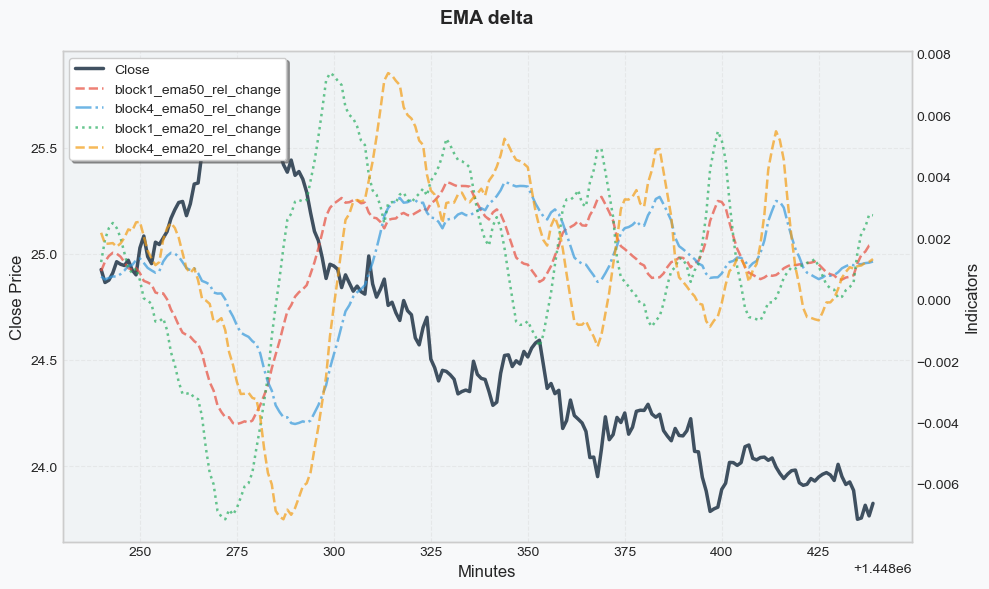

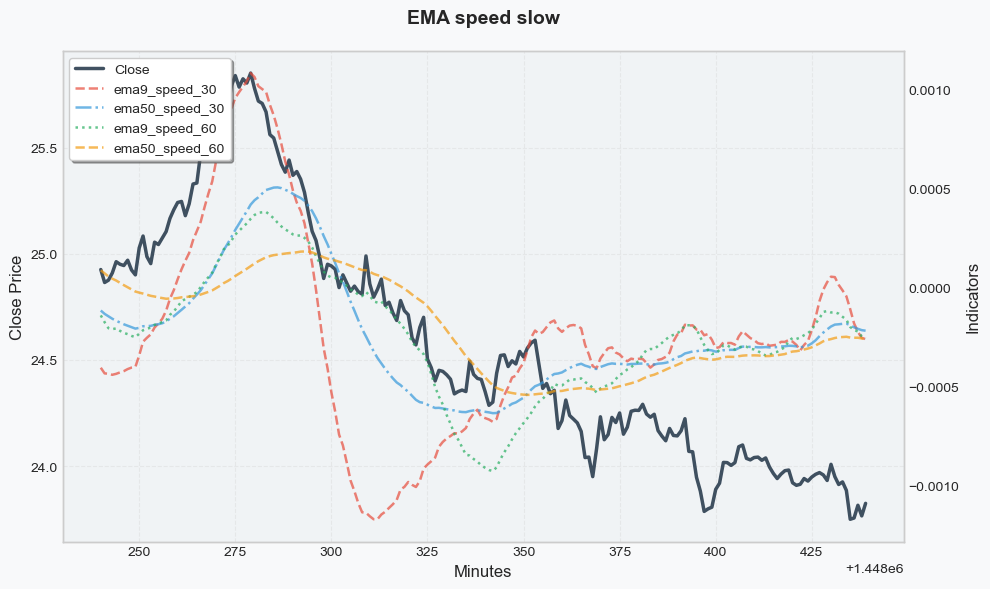

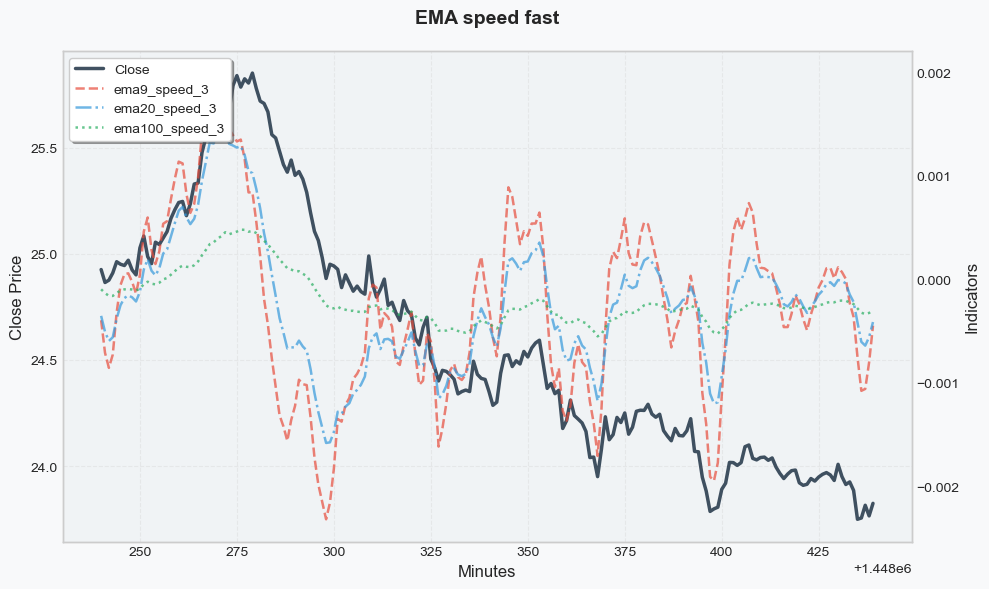

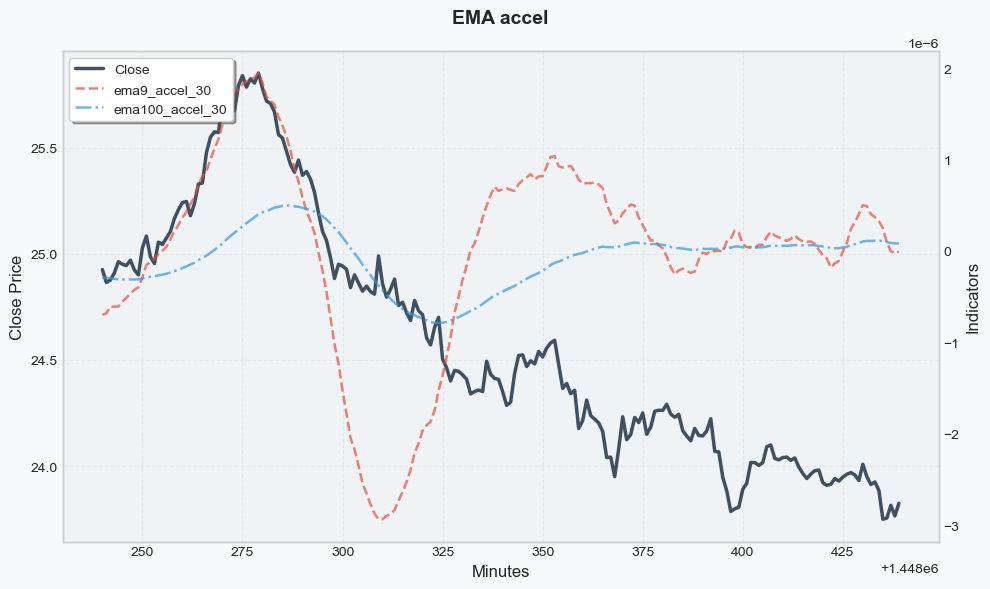

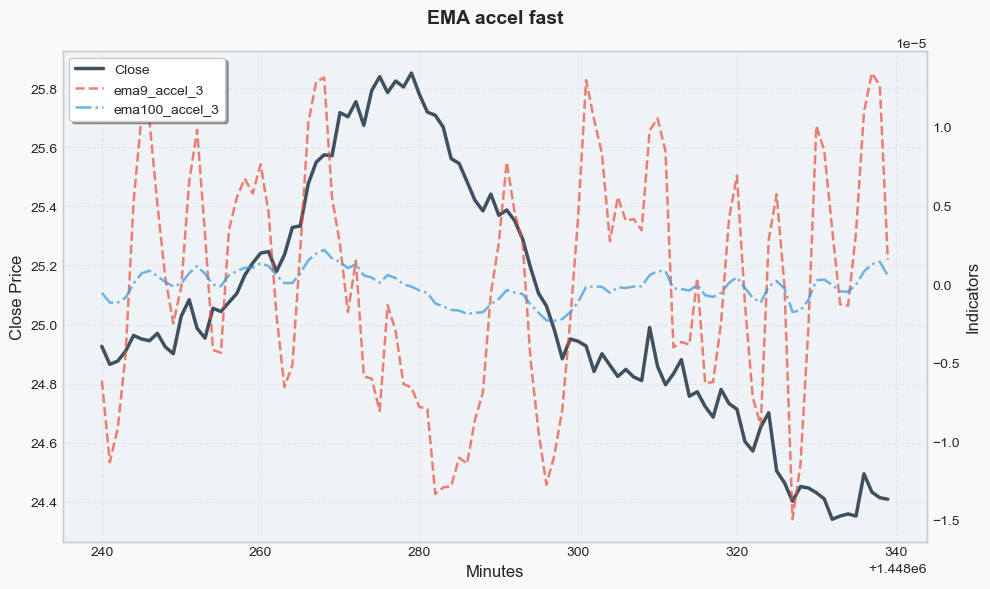

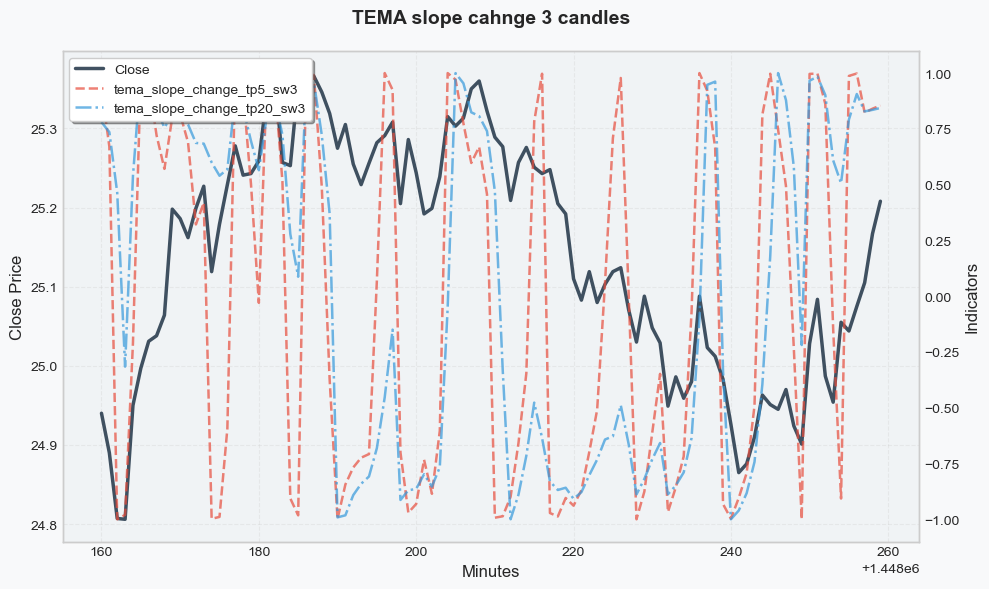

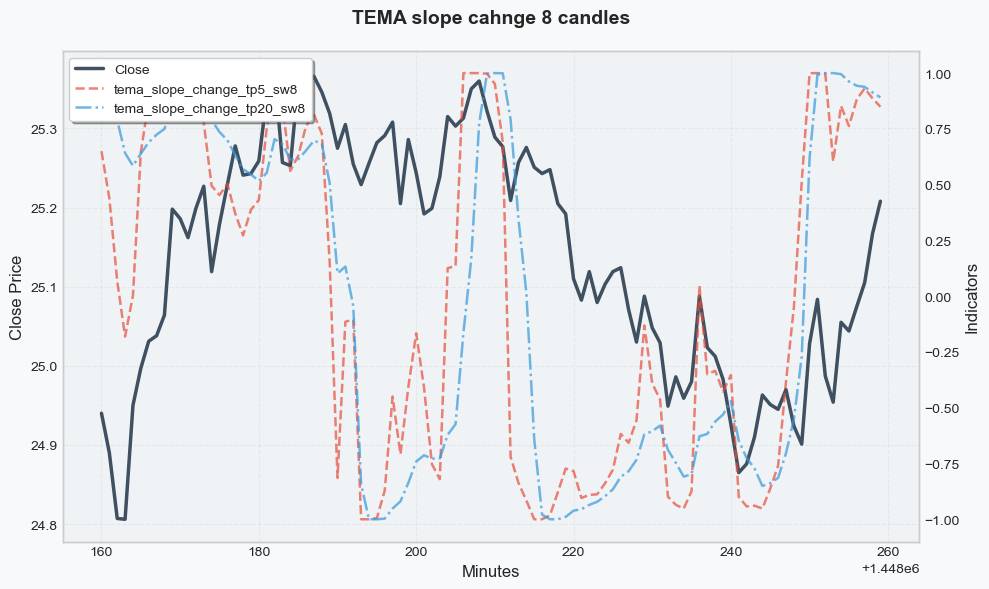

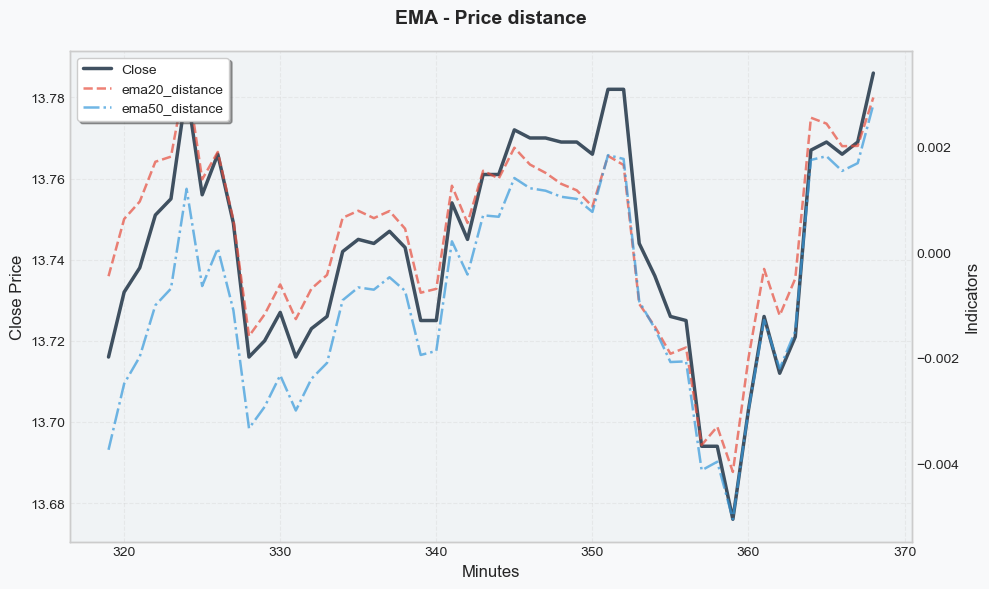

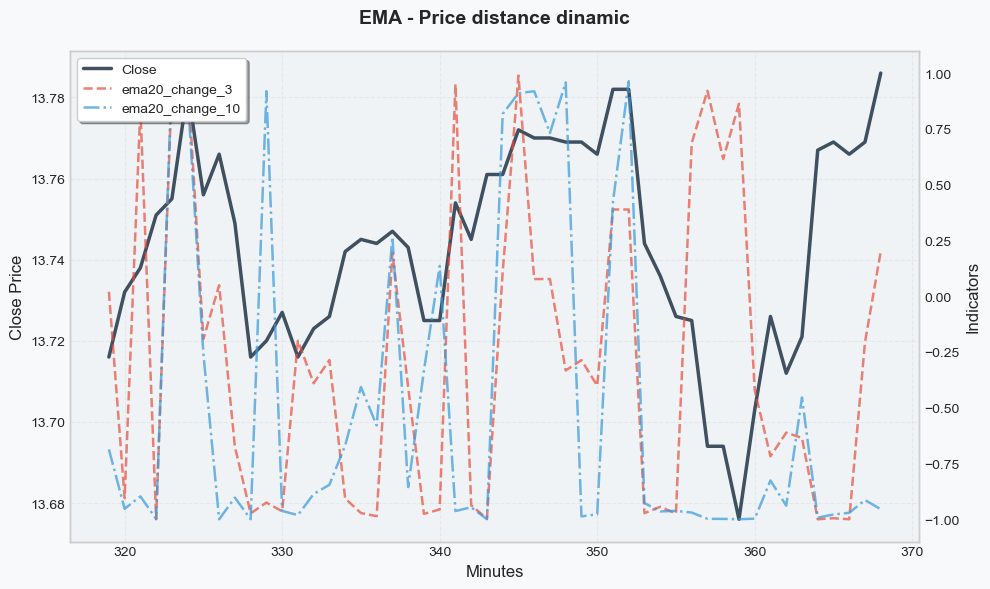

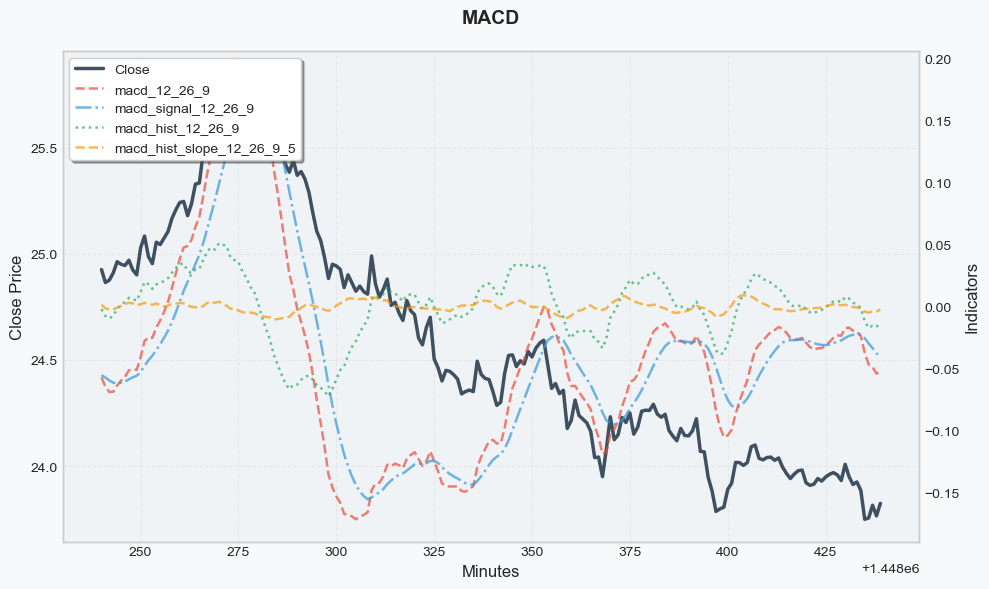

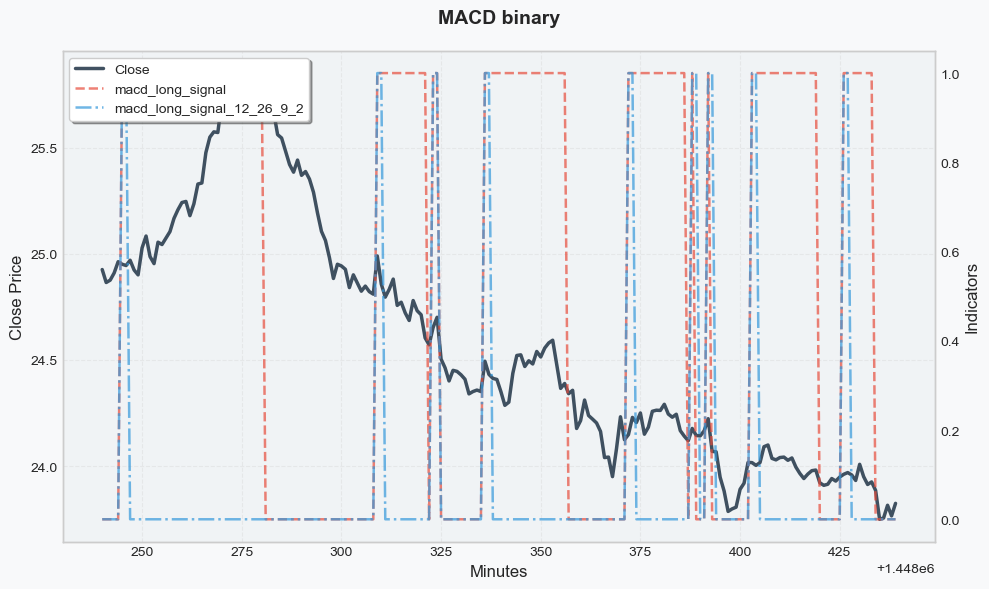

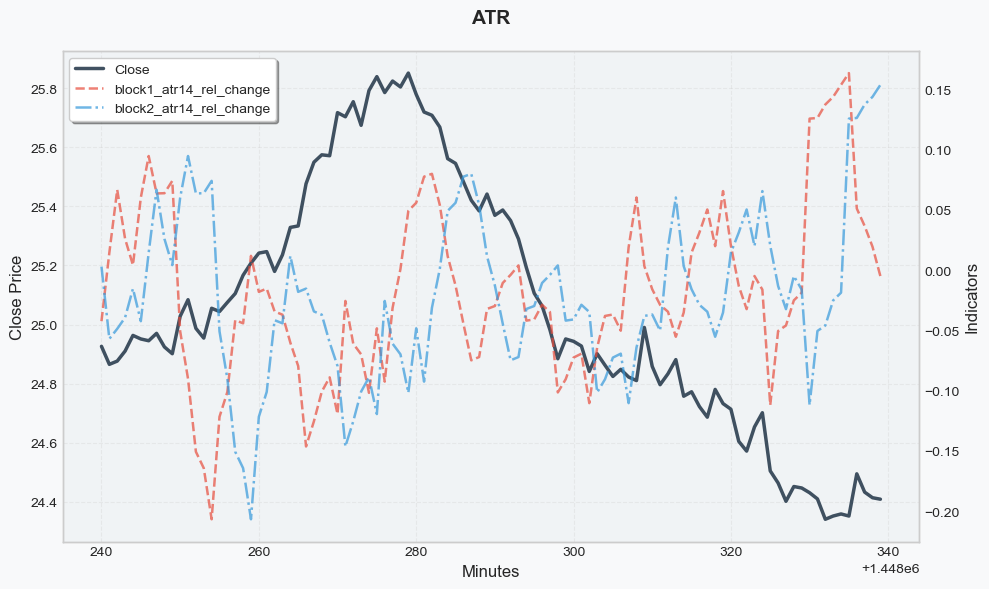

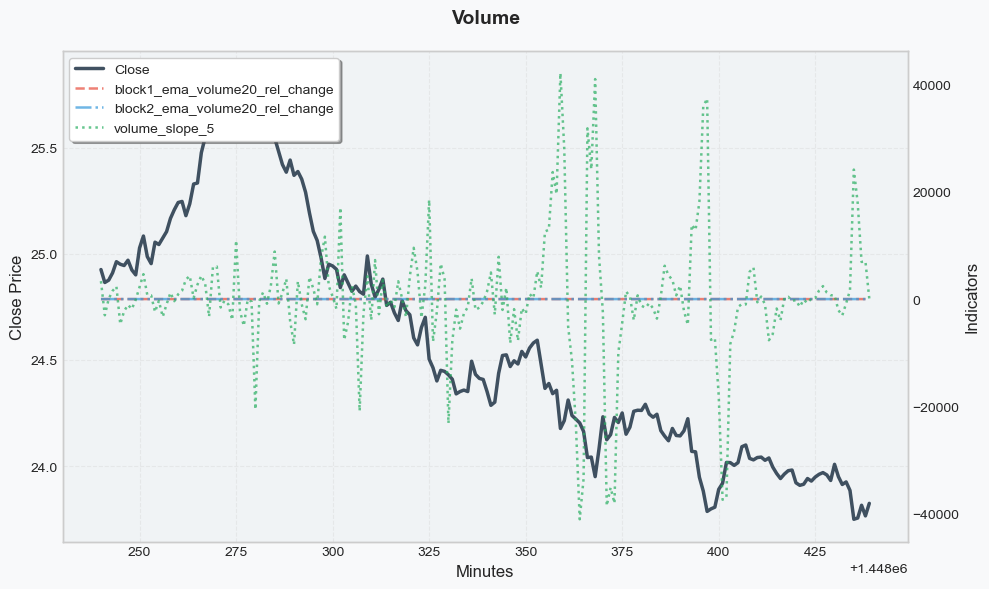

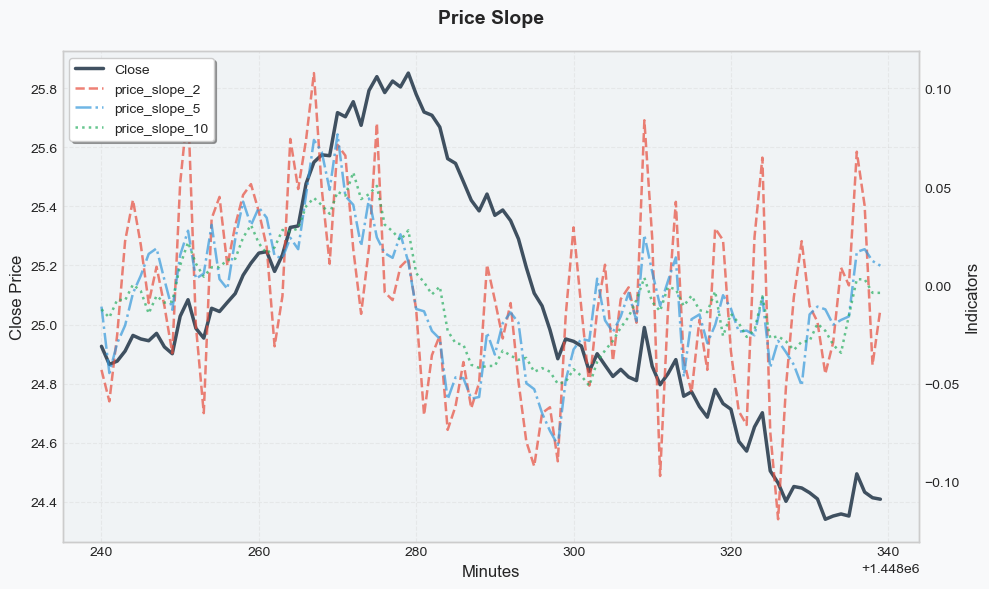

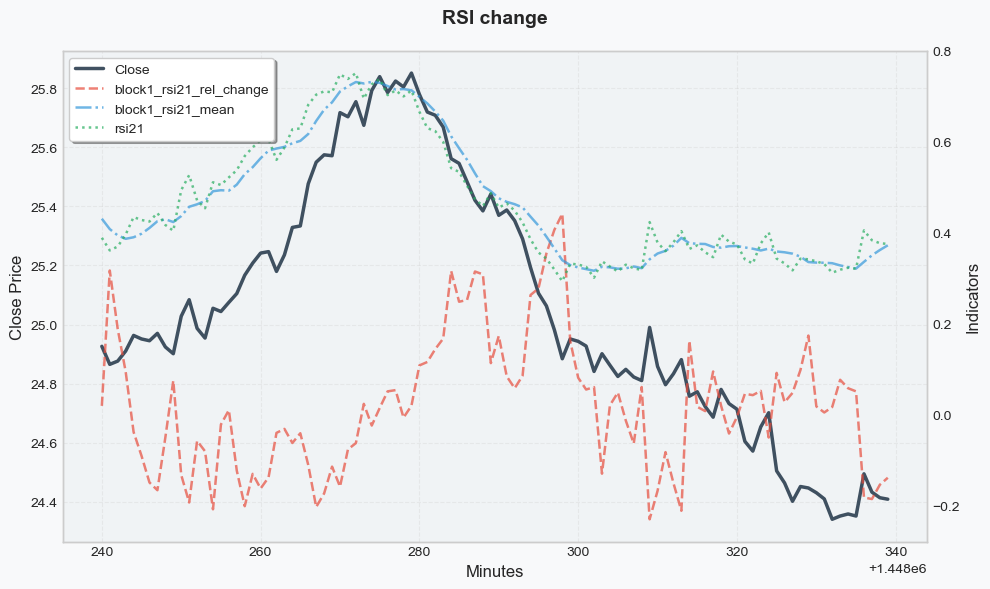

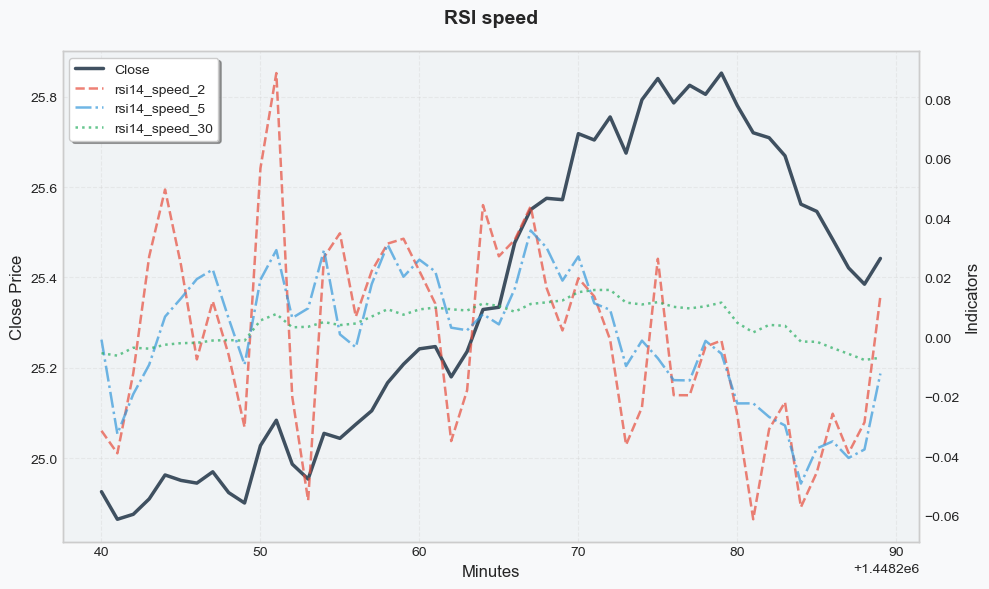

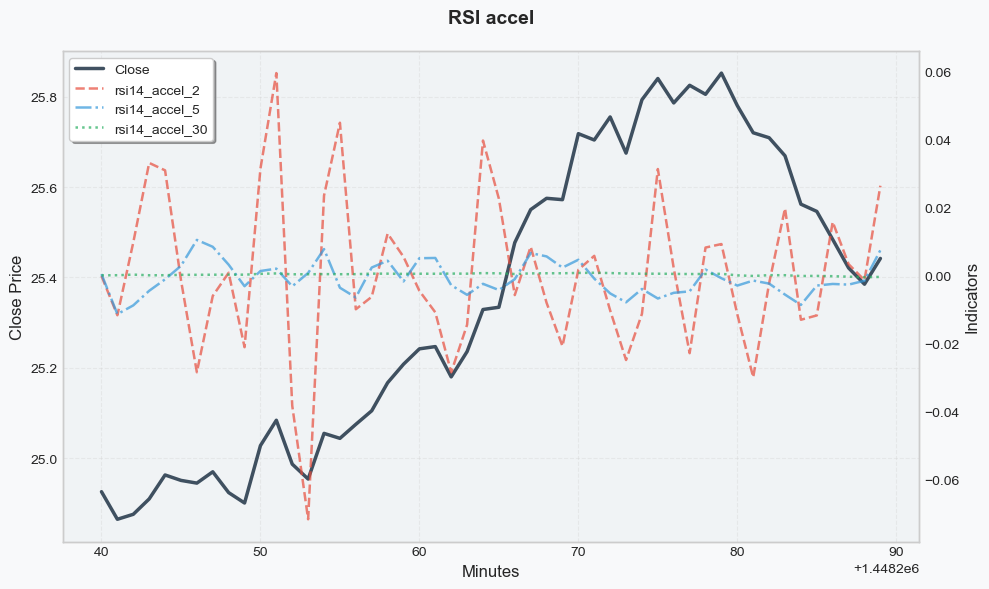

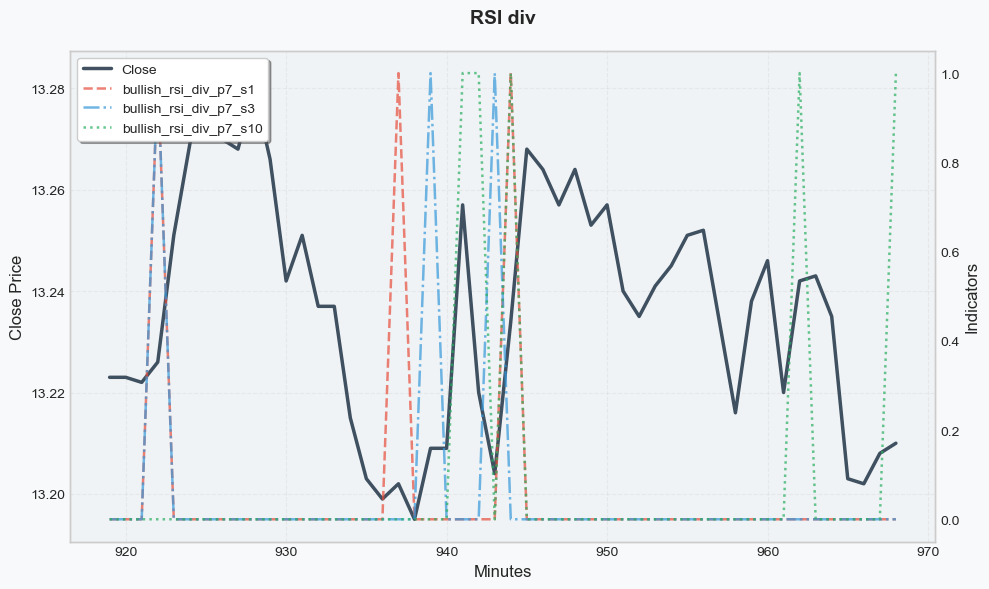

In [76]:
plot_price_with_indicators(df, indicators=['block1_ema50_rel_change', 'block4_ema50_rel_change', 'block1_ema20_rel_change', 'block4_ema20_rel_change'], title="EMA delta")
plot_price_with_indicators(df, indicators=['ema9_speed_30', 'ema50_speed_30', 'ema9_speed_60', 'ema50_speed_60'], title="EMA speed slow")
plot_price_with_indicators(df, indicators=['ema9_speed_3', 'ema20_speed_3', 'ema100_speed_3'], title="EMA speed fast")
plot_price_with_indicators(df, indicators=['ema9_accel_30', 'ema100_accel_30'], title="EMA accel")
plot_price_with_indicators(df, indicators=['ema9_accel_3', 'ema100_accel_3'], start=-400, end=-300, title="EMA accel fast")
plot_price_with_indicators(df, indicators=['tema_slope_change_tp5_sw3', 'tema_slope_change_tp20_sw3'],start=-480, end=-380, title="TEMA slope cahnge 3 candles")
plot_price_with_indicators(df, indicators=['tema_slope_change_tp5_sw8', 'tema_slope_change_tp20_sw8'],start=-480, end=-380, title="TEMA slope cahnge 8 candles")
plot_price_with_indicators(df, indicators=['ema20_distance', 'ema50_distance'],start=100, end=150, title="EMA - Price distance")
plot_price_with_indicators(df, indicators=['ema20_change_3', 'ema20_change_10'],start=100, end=150, title="EMA - Price distance dinamic")
plot_price_with_indicators(df, indicators=['macd_12_26_9', 'macd_signal_12_26_9', 'macd_hist_12_26_9', 'macd_hist_slope_12_26_9_5'], title="MACD")
plot_price_with_indicators(df, indicators=['macd_long_signal', 'macd_long_signal_12_26_9_2'], title="MACD binary")
plot_price_with_indicators(df, indicators=['block1_atr14_rel_change', 'block2_atr14_rel_change'], start=-400, end=-300, title="ATR")
plot_price_with_indicators(df, indicators=['block1_ema_volume20_rel_change', 'block2_ema_volume20_rel_change','volume_slope_5'], title="Volume")
plot_price_with_indicators(df, indicators=['price_slope_2', 'price_slope_5', 'price_slope_10',], start=-400, end=-300, title="Price Slope")
plot_price_with_indicators(df,indicators=['block1_rsi21_rel_change', 'block1_rsi21_mean', 'rsi21'], start=-400, end=-300, title="RSI change")
plot_price_with_indicators(df,indicators=['rsi14_speed_2', 'rsi14_speed_5', 'rsi14_speed_30'], start=-400, end=-350, title="RSI speed")
plot_price_with_indicators(df,indicators=['rsi14_accel_2', 'rsi14_accel_5', 'rsi14_accel_30'], start=-400, end=-350, title="RSI accel")
plot_price_with_indicators(df,indicators=['bullish_rsi_div_p7_s1', 'bullish_rsi_div_p7_s3', 'bullish_rsi_div_p7_s10'], start=700, end=750, title="RSI div")

# 🔗 6. Корреляционный анализ

## Корреляция признаков и целевой переменной

**plot_correlation_matrix** Строит тепловую карту корреляций целевой переменной и признаками

Вход:
- df с признаками и целевой переменной
- drop_columns базовые/промежуточные колонки не требующие исследования
- top_n - фильтр по корреляции
- target - целевая переменная

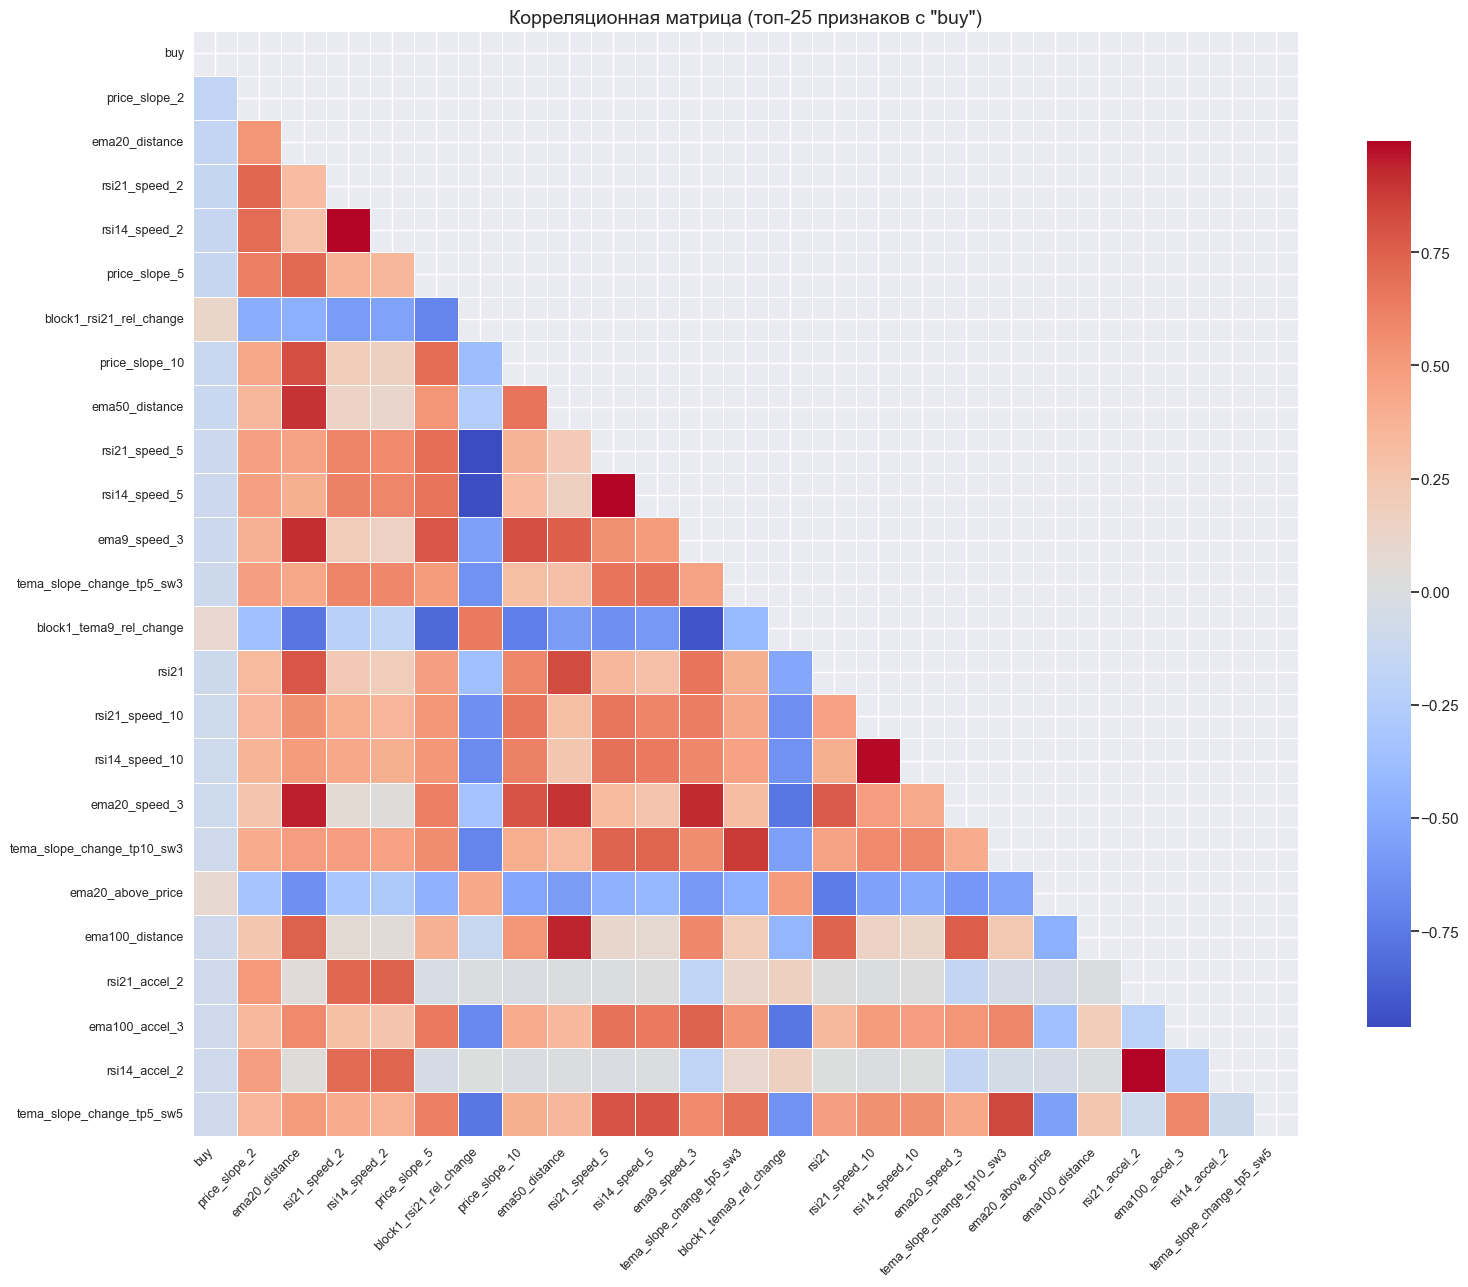

In [119]:
plot_correlation_matrix(df, target='buy', drop_columns=['sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume'], top_n=25)

In [80]:
correlations = df.drop(['sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume'], axis=1).corr()[['buy']].sort_values(by='buy', key=lambda x: x.abs(), ascending=False)

In [81]:
correlations.head(10)

buy
buy                      1.000000
price_slope_2           -0.171673
ema20_distance          -0.151263
rsi21_speed_2           -0.143720
rsi14_speed_2           -0.140548
price_slope_5           -0.136274
block1_rsi21_rel_change  0.122880
price_slope_10          -0.115633
ema50_distance          -0.113098
rsi21_speed_5           -0.110308

## Влияние значимости признаков от их удаления от текущей свечи

**plot_corr_by_distance** Строит график средней корреляции (по модулю) между target и всеми признаками.
- по оси **y** указаны значения корреляции между целевой переменной **target** и признаками
- по оси **x** отложено расстояние от текущей закрытой свечи до свечей на которых был проведен расчет признака

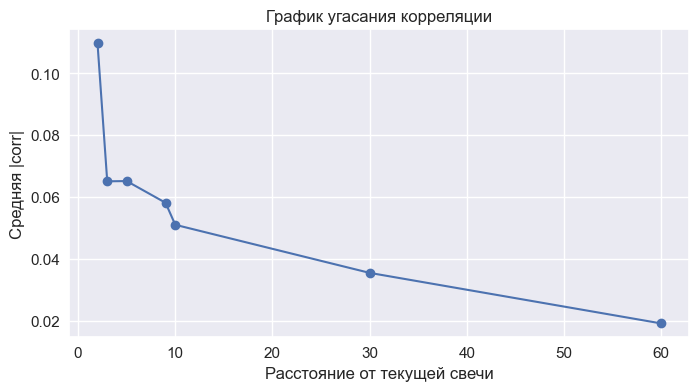

In [125]:
plot_corr_by_distance(df, target='buy')

# ✂️ 7. Разбиение выборки

## Разбиение выборки на train и valid

In [18]:
#Разбиваем выборку с учетом временных рядов:

X = df.drop(['buy', 'sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume'],axis=1)
y = df['buy']
separate = int(len(X) * 0.8)
X_train = X.iloc[:separate]
X_valid = X.iloc[separate:]
y_train = y.iloc[:separate]
y_valid = y.iloc[separate:]
feature_columns = X.columns.tolist()

print(f'размер датасета = {df.shape}')
print(f'размер обучающей выборки Х = {X_train.shape}, y = {y_train.shape}')
print(f'размер валидационной выборки Х = {X_valid.shape}, y = {y_valid.shape}')

размер датасета = (1448421, 139)
размер обучающей выборки Х = (1158736, 127), y = (1158736,)
размер валидационной выборки Х = (289685, 127), y = (289685,)


Разбиение тестовой выборки **X_test**, **y-test**

In [21]:
X_test = df_test.drop(['buy', 'sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume'],axis=1)
y_test = df_test['buy']


print(f'размер датасета = {X_test.shape}')

размер датасета = (305061, 127)


## Проверка временных диапазонов

Проверка временных диапазонов. Даты обучающей и тестовой выборок не должны пересекаться.

In [92]:
print(f"Диапазон дат обучающей выборки {df['Date'].agg(['min', 'max'])}")
print(f"Диапазон дат отложенной (тестовой) выборки {df_test['Date'].agg(['min', 'max'])}")

Диапазон дат обучающей выборки min    2022-03-10 00:40:00
max    2024-12-09 21:00:00
Name: Date, dtype: object
Диапазон дат отложенной (тестовой) выборки min    2024-12-12 00:40:00
max    2025-07-11 21:00:00
Name: Date, dtype: object


# 🎯 8. Распределение целевой переменной (buy)

**Цель**: определение дисбаланса классов

## Распределение целевой переменной на всем df

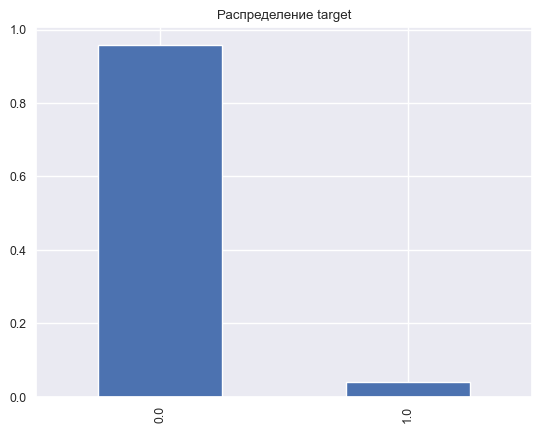

In [96]:
df['buy'].value_counts(normalize=True).plot(kind='bar', title='Распределение target');

## Распределение целевой переменной внутри выборок

**show_class_balance** Анализирует и визуализирует распределение классов по выборкам

Вход:
- y: целевая переменная всего датасета
- y_train: обучающая выборка
- y_valid: валидационная выборка
- y_test: тестовая выборка

Выход:
- Таблица с долями классов в каждой выборке
- Столбчатая диаграмма распределения
- Визуальная проверка сбалансированности данных

Что делает: Сравнивает пропорции классов между разными выборками для контроля репрезентативности разбиения

📊 Баланс классов (доли):
         Весь датасет    Обучающая    Валидационная    Тестовая
-----  --------------  -----------  ---------------  ----------
0.000           0.958        0.958            0.957       0.943
1.000           0.042        0.042            0.043       0.057


<Figure size 1000x500 with 0 Axes>

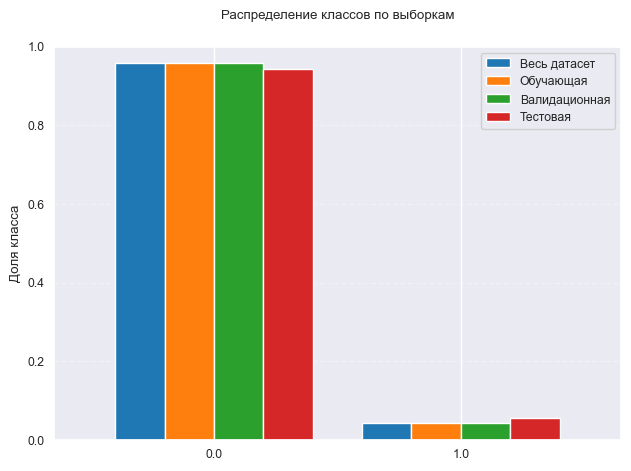

In [692]:
show_class_balance(y, y_train, y_valid, y_test)

# 📊 9. Важность признаков (Mutual Information)

**mutual_info_classif** вычисляет взаимную информацию между каждым признаком и целевой переменной.\

Входные данные:
- X_train — матрица признаков
- y_train — целевая переменная
- top_n — количество топ-признаков для отображения
- random_state — seed для воспроизводимости

Процесс работы:
- Вычисляет Mutual Information между каждым признаком и целевой переменной
- Сортирует признаки по убыванию важности
- Выводит таблицу топ-N наиболее информативных признаков
- Строит горизонтальный барчарт для наглядной визуализации

Особенности:
- Работает с категориальными и числовыми признаками
- Оценивает нелинейные зависимости: Может выявить сложные связи, которые пропускает линейная корреляция

ℹ️ Calculating Mutual Information for 106 features...
✅ MI calculation completed in 1667.70 seconds

🔍 Top 10 Features by Mutual Information:
| Feature                  |   MI_Score |
|:-------------------------|-----------:|
| macd_long_signal         |     0.1378 |
| ema20_above_price        |     0.1352 |
| ema50_above_price        |     0.1339 |
| ema100_above_price       |     0.1333 |
| atr14_grow_blocks        |     0.0990 |
| ema_volume20_grow_blocks |     0.0982 |
| ema200_grow_blocks       |     0.0918 |
| rsi21_grow_blocks        |     0.0896 |
| ema50_grow_blocks        |     0.0626 |
| ema20_grow_blocks        |     0.0554 |


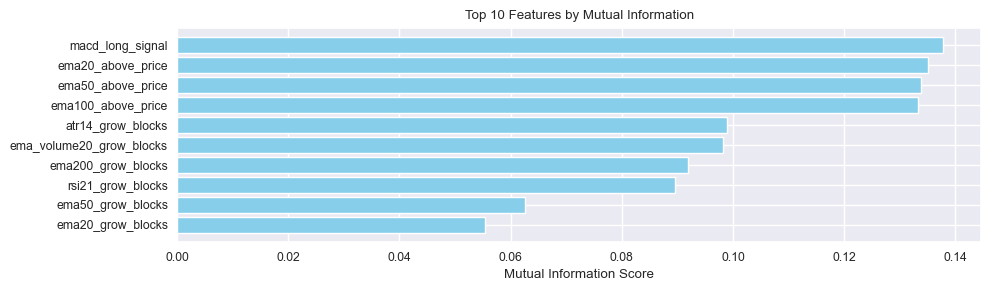

In [121]:
explain_model_mutual_info(X_train, y_train, top_n=10)

Точечный график распределения **целевой переменной**.\
Визуализация парных взаимосвязей между признаками и целевой переменной

In [151]:
df.head(1)

Open    High     Low   Close  Volume                 Date  buy_noised  \
0  13.982  13.984  13.981  13.984    28.3  2022-03-10 00:40:00         0.0   

   sell_noised  buy  sell  buy_strong  sell_strong  block1_ema20_rel_change  \
0          0.0  0.0   0.0         0.0          0.0                 0.001493   

   block2_ema20_rel_change  block3_ema20_rel_change  block4_ema20_rel_change  \
0                 0.002633                 0.001484                 0.000451   

   ema20_grow_blocks  block1_ema50_rel_change  block2_ema50_rel_change  \
0                  4                 0.001094                 0.001375   

   block3_ema50_rel_change  block4_ema50_rel_change  ema50_grow_blocks  \
0                 0.000724                 0.000191                  4   

   block1_ema200_rel_change  block2_ema200_rel_change  \
0                  0.000373                  0.000399   

   block3_ema200_rel_change  block4_ema200_rel_change  ema200_grow_blocks  \
0                  0.000201                  0.000049                   4   

   block1_tema9_rel_change  block2_tema9_rel_change  block3_tema9_rel_change  \
0                -0.001251                 0.005188                  0.00303   

   block4_tema9_rel_change  tema9_grow_blocks  ema20_above_price  \
0                  0.00197                  3                  1   

   ema50_above_price  ema100_above_price  ema9_speed_3  ema9_accel_3  \
0                  1                   0     -0.000115      0.000004   

   ema9_speed_10  ema9_accel_10  ema9_speed_30  ema9_accel_30  ema9_speed_60  \
0      -0.000404      -0.000002      -0.000032  -2.778663e-07       0.000026   

   ema9_accel_60  ema20_speed_3  ema20_accel_3  ema20_speed_10  \
0  -1.271990e-07      -0.000179       0.000002        -0.00029   

   ema20_accel_10  ema20_speed_30  ema20_accel_30  ema20_speed_60  \
0       -0.000002        0.000018   -2.372277e-07        0.000068   

   ema20_accel_60  ema50_speed_3  ema50_accel_3  ema50_speed_10  \
0   -5.019634e-08      -0.000068   4.290515e-07       -0.000086   

   ema50_accel_10  ema50_speed_30  ema50_accel_30  ema50_speed_60  \
0       -0.000001         0.00008   -1.705253e-07        0.000116   

   ema50_accel_60  ema100_speed_3  ema100_accel_3  ema100_speed_10  \
0    6.606453e-08         0.00001    9.677629e-08         0.000008   

   ema100_accel_10  ema100_speed_30  ema100_accel_30  ema100_speed_60  \
0    -8.186474e-07         0.000097    -6.643666e-08         0.000111   

   ema100_accel_60  macd_long_signal  macd_rel_change_2  macd_rel_change_5  \
0     9.309695e-08                 0           0.022597           0.067643   

   macd_rel_change_10  macd_signal_rel_change_2  macd_signal_rel_change_5  \
0           -3.612251                  0.340988                  8.616011   

   macd_signal_rel_change_10  macd_hist_rel_change_2  macd_hist_rel_change_5  \
0                   -1.77792               -0.330373               -0.640958   

   macd_hist_rel_change_10  macd_long_signal_lastN  block1_atr14_rel_change  \
0                -0.383165                       0                 0.096233   

   block2_atr14_rel_change  atr14_grow_blocks  block1_ema_volume20_rel_change  \
0                -0.000009                  1                        0.423763   

   block2_ema_volume20_rel_change  ema_volume20_grow_blocks  price_slope_2  \
0                        0.158366                         2      -0.000248   

   price_slope_5  price_slope_10  volume_slope_5  volume_slope_10  \
0       0.000213       -0.000334       -0.000198        -0.000178   

   block1_rsi21_rel_change  block1_rsi21_mean  block2_rsi21_rel_change  \
0                -0.106163          40.019915                 0.208174   

   block2_rsi21_mean  block3_rsi21_rel_change  block3_rsi21_mean  \
0          36.200881                 0.068727          43.354887   

   block4_rsi21_rel_change  block4_rsi21_mean  rsi21_grow_blocks  \
0                 0.124687          49.930226                  3   

   rsi14

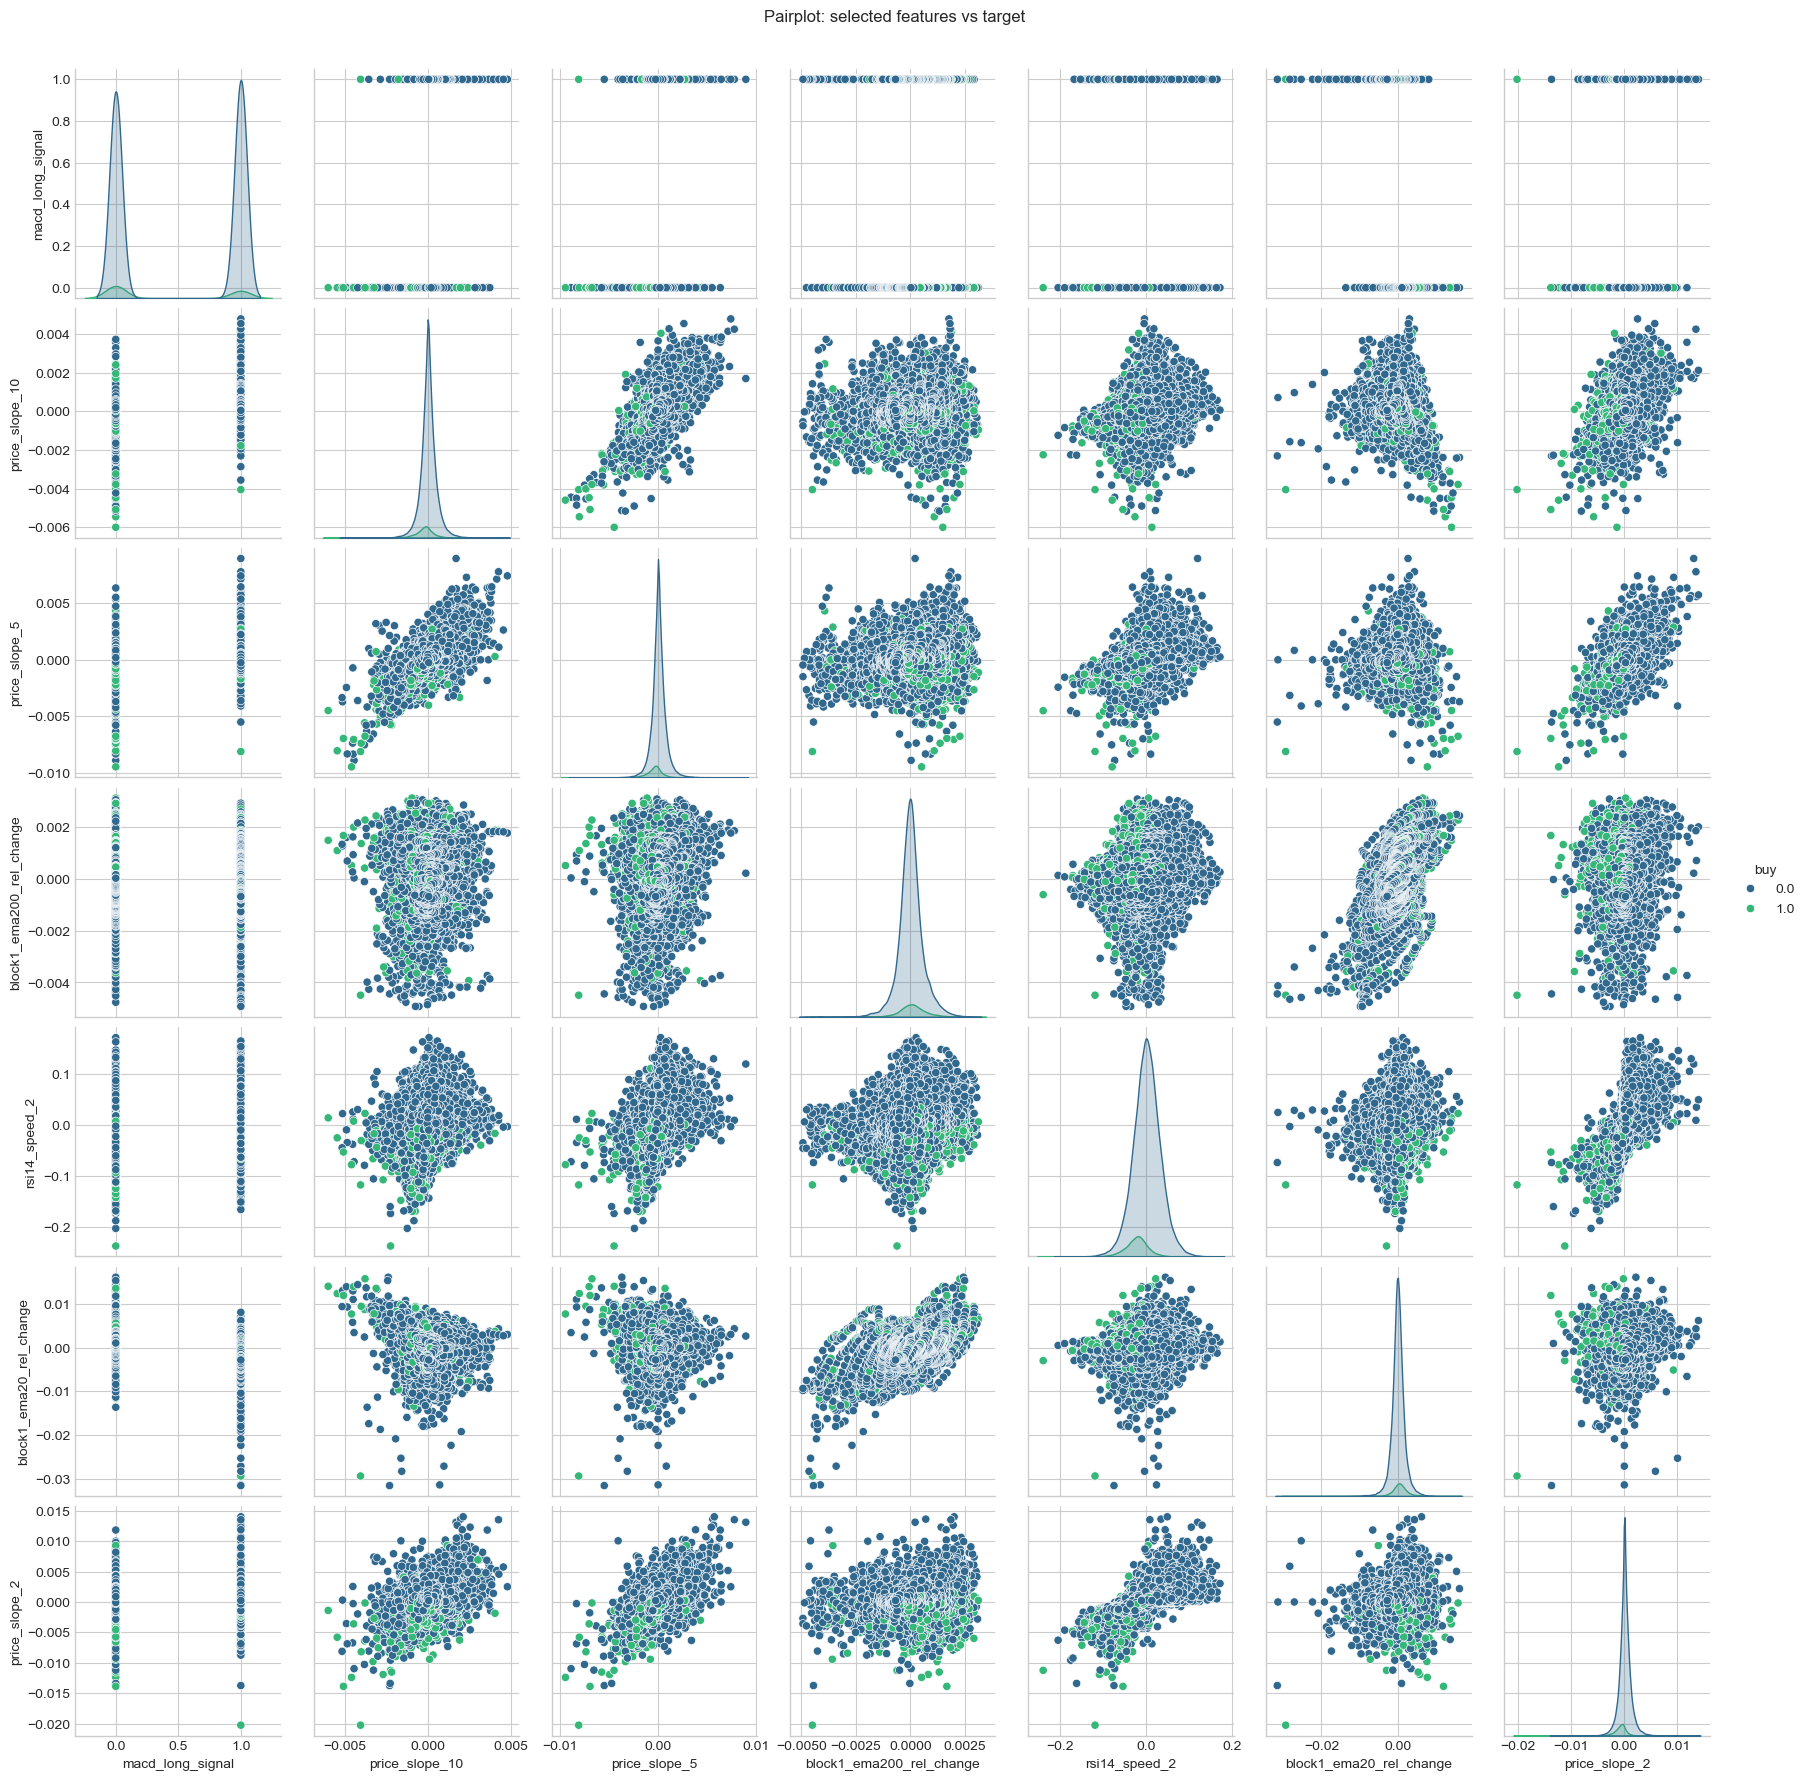

In [84]:
df_cut = df.iloc[100000:200000]

# Список признаков для визуализации
features_list = [
    'macd_long_signal',
    'price_slope_10',
    'price_slope_5',
    'block1_ema200_rel_change',
    'rsi14_speed_2',
    'block1_ema20_rel_change',
    'price_slope_2'
]
columns_to_plot = features_list + ['buy']
subset_df = df_cut[columns_to_plot].dropna()
sns.pairplot(subset_df, hue='buy', diag_kind='kde', palette='viridis')
plt.suptitle('Pairplot: selected features vs target', y=1.02)
plt.show()

# 🤖 10. Обучение моделей

## Логистическая регрессия - base line

In [131]:
start_time = time.time()

logreg = LogisticRegression(
        class_weight='balanced',
        random_state=3,
        max_iter=100,  
        n_jobs=-1,      
        solver='lbfgs'  
    )
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)

print(f'✅ F1 score (buy): {f1:.4f}')
print(f'✅ Precision (buy): {precision:.4f}')
print(f'✅ Recall (buy): {recall:.4f}')
# Сохраняем модель
trained_logreg = logreg    

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (buy): 0.1310
✅ Precision (buy): 0.0727
✅ Recall (buy): 0.6635
⏱ Время выполнения: 42.96 сек


### Предсказание LogReg модели на отложенной выборке

In [133]:
# Предсказание
y_pred = trained_logreg.predict(X_test)


# Расчет метрик
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
target_name = 'buy'    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

✅ F1 score (buy): 0.1714
✅ Precision (buy): 0.0980
✅ Recall (buy): 0.6814


## Случайный лес - base line

In [147]:
start_time = time.time()
target_name = 'buy'

# Более оптимальные параметры
forest_base_line = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=6,
    max_features=0.7,
    max_samples=0.7,
    random_state=3,
    n_jobs=6
)

# Обучение с кросс-валидацией (опционально)
forest = forest_base_line.fit(X_train, y_train)

# Предсказание
y_pred = forest_base_line.predict(X_valid)

# Расчет метрик
f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (buy): 0.1656
✅ Precision (buy): 0.0924
✅ Recall (buy): 0.7956
⏱ Время выполнения: 2591.28 сек


### Предсказание RandomForest на отложенной выборке

In [149]:
# Предсказание
y_pred = forest_base_line.predict(X_test)
y_pred_proba = forest_base_line.predict_proba(X_valid)[:, 1]

# Расчет метрик
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

✅ F1 score (buy): 0.1955
✅ Precision (buy): 0.1108
✅ Recall (buy): 0.8287


In [32]:
forest_base_line.feature_names_in_

array(['block1_ema20_rel_change', 'block2_ema20_rel_change',
       'block3_ema20_rel_change', 'block4_ema20_rel_change',
       'ema20_grow_blocks', 'block1_ema50_rel_change',
       'block2_ema50_rel_change', 'block3_ema50_rel_change',
       'block4_ema50_rel_change', 'ema50_grow_blocks',
       'block1_ema200_rel_change', 'block2_ema200_rel_change',
       'block3_ema200_rel_change', 'block4_ema200_rel_change',
       'ema200_grow_blocks', 'block1_tema9_rel_change',
       'block2_tema9_rel_change', 'block3_tema9_rel_change',
       'block4_tema9_rel_change', 'tema9_grow_blocks',
       'ema20_above_price', 'ema50_above_price', 'ema100_above_price',
       'ema9_speed_3', 'ema9_accel_3', 'ema9_speed_10', 'ema9_accel_10',
       'ema9_speed_30', 'ema9_accel_30', 'ema9_speed_60', 'ema9_accel_60',
       'ema20_speed_3', 'ema20_accel_3', 'ema20_speed_10',
       'ema20_accel_10', 'ema20_speed_30', 'ema20_accel_30',
       'ema20_speed_60', 'ema20_accel_60', 'ema50_speed_3',
       'em

### Сохранения модели RandomForest Base line

Назначение: **save_model_with_threshold** Сохраняет обученную модель вместе с параметрами, порогом классификации и списком признаков в сжатом формате.

Входные данные:
- model_name — название модели (без расширения)
- model — обученная модель
- params — гиперпараметры модели
- threshold — оптимальный порог классификации
- features — список используемых признаков
- compress — уровень сжатия (0-9)

Особенности:
- Автоматически создает папку model_exports
- Сохраняет все необходимые компоненты для развертывания
- Поддержка сжатия для экономии места

Выход: Файл .pkl в папке model_exports с полным набором данных для восстановления работы модели.

In [153]:
# Сохранение новой модели
save_model_with_threshold(
    model_name='forest_base_line',
    model=forest_base_line,
    params=forest_base_line.get_params,
    threshold=0.5,
    features = list(X_train.columns)
)

✅ Модель сохранена в model_exports\forest_base_line_with_threshold.pkl (сжатие: уровень 3)


### Загрузка модели RandomForest

Назначение: **load_model_with_threshold** Загружает ранее сохраненную модель вместе с параметрами, порогом и признаками из папки model_exports.

Входные данные:
- model_name — название модели (без расширения и суффикса)

Особенности:
- Автопоиск файлов в нескольких расположениях:
 - Папка ../model_exports (относительно модуля)
 - Папка model_exports (текущая директория)
- Проверка целостности данных (наличие всех необходимых ключей)
- Информативное сообщение об ошибке с списком доступных моделей

Выходные данные:\
Словарь с ключами: model, params, threshold, features

In [12]:
import joblib
forest_base_line_package = load_model_with_threshold('forest_base_line')  # Обратите внимание на имя переменной
forest_base_line = forest_base_line_package['model']
forest_base_line_params = forest_base_line_package['params']
forest_base_line_threshold = forest_base_line_package['threshold']

✅ Модель 'forest_base_line' загружена из C:\Users\nikita\Documents\MagisterML\MyJupiter\trading_project\modules\..\model_exports\forest_base_line_with_threshold.pkl


# 🎯 11. Метрики качества

Сравнение метрик **Random Forest** и **LogisticRegression**

In [23]:
y_proba_forest = forest_base_line.predict_proba(X_valid)[:, 1]       # Предсказанная вероятность
y_pred_forest = (y_proba_forest >= 0.5).astype(int)             # Базовый порог = 0.5
print('Метрики для модели Random Forest')
print("Precision:", precision_score(y_valid, y_pred_forest))
print("Recall:", recall_score(y_valid, y_pred_forest))
print("F1 Score:", f1_score(y_valid, y_pred_forest))
print()

Метрики для модели Random Forest
Precision: 0.09242556673423466
Recall: 0.7956455615144481
F1 Score: 0.1656128424928565



Построение **precision-recall** кривой для модели с наивысшим значением **f1**.\
Позволяет визуально выбрать лучший порог вероятности:

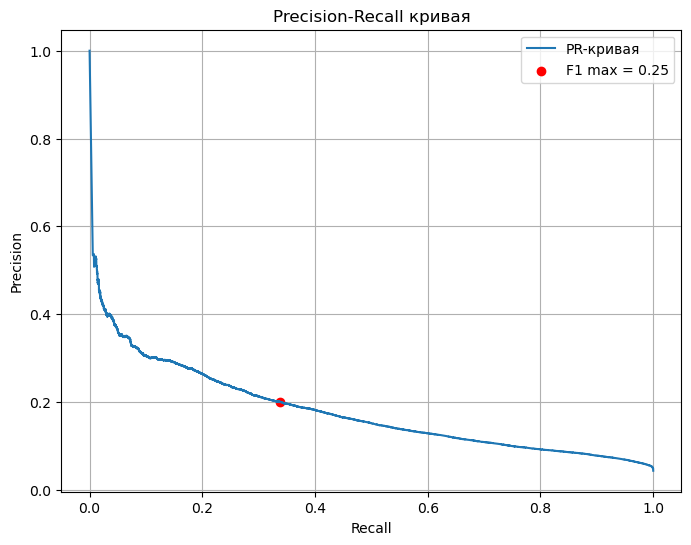

🔎 Лучший порог = 0.743, F1 = 0.252


In [26]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba_forest)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR-кривая")
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"F1 max = {f1_scores[best_idx]:.2f}")
plt.title("Precision-Recall кривая")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

print(f"🔎 Лучший порог = {best_threshold:.3f}, F1 = {f1_scores[best_idx]:.3f}")

# ⚖️ 12. Анализ порога классификации

**evaluate_model_with_threshold** Оценивает модель с подбором оптимального порога и возвращает результаты

Вход:
- model: обученная модель классификации
- X_train, y_train: обучающая выборка
- X_valid, y_valid: валидационная выборка
- X_test, y_test: тестовая выборка (опционально)

Выход:
- Словарь с моделью, метриками и метаданными:
- Обученная модель
- Метрики (F1, Precision, Recall, ROC AUC) для всех выборок
- Оптимальный порог классификации
- Список использованных признаков

🎯 Лучший порог по F1 (Train): 0.7400
🎯 Лучший порог по F1 (Valid): 0.7400
✅ Усредненный оптимальный порог: 0.7400

📊 ROC AUC Scores:
✅ Train ROC AUC: 0.8266
✅ Valid ROC AUC: 0.8075

📊 Train set (Threshold = 0.7400):
✅ F1: 0.2642
✅ Precision: 0.2132
✅ Recall: 0.3473
✅ ROC AUC: 0.8266

📊 Valid set (Threshold = 0.7400):
✅ F1: 0.2507
✅ Precision: 0.1971
✅ Recall: 0.3444
✅ ROC AUC: 0.8075

📊 Test set (Threshold = 0.7400):
✅ F1: 0.2625
✅ Precision: 0.1936
✅ Recall: 0.4074
✅ ROC AUC: 0.7970


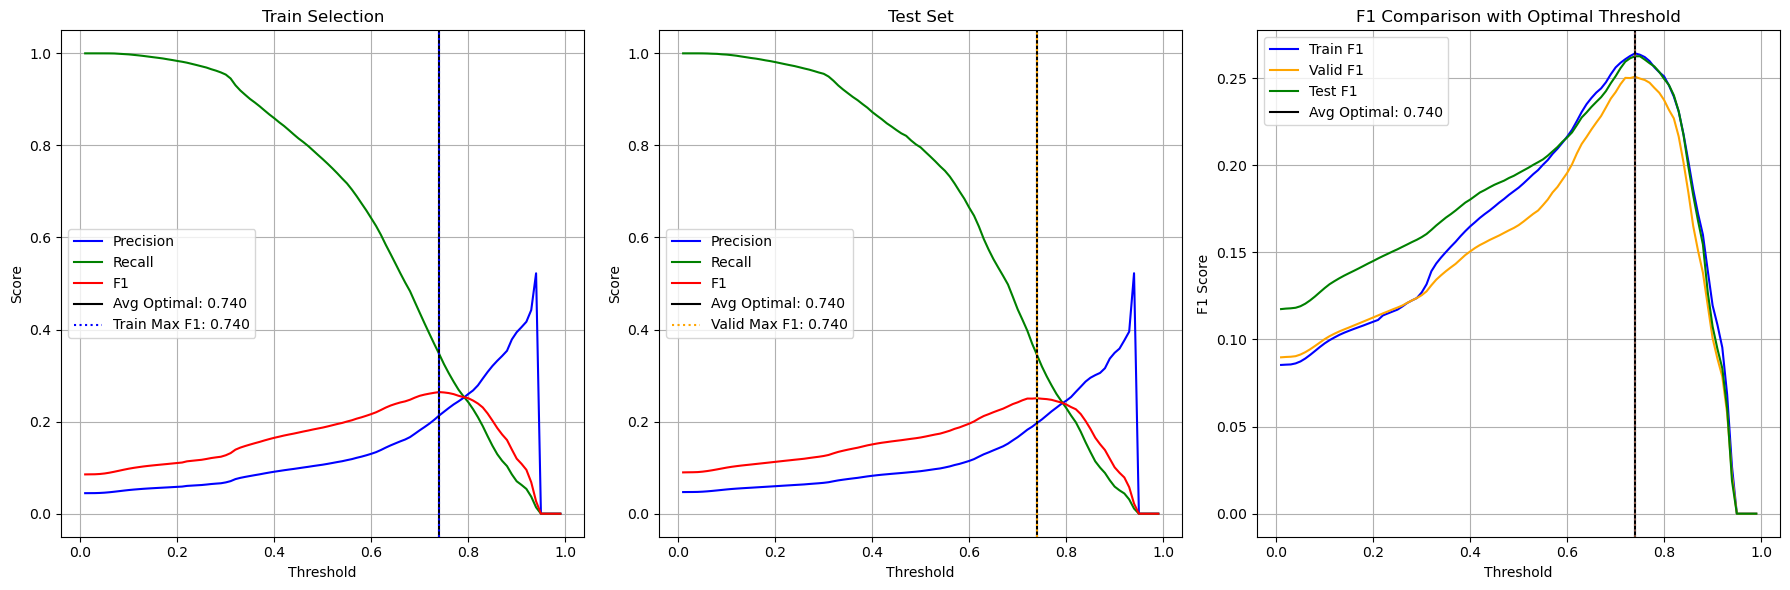

In [34]:
forest_base_line_package = evaluate_model_with_threshold(forest_base_line, X_train, y_train, X_valid, y_valid, X_test, y_test)

# 🔍 13. Интерпретация модели

## SHAP-анализ важности признаков модели

Функция **explain_model_shap**: 
- Вычисляет SHAP-значения для интерпретации модели
- Анализирует важность и направление влияния признаков
- Визуализирует топ-N наиболее значимых признаков

Входные данные:
- X_train — датафрейм с признаками
- model — обученная модель (RandomForest, XGBoost, LogisticRegression и др.)
- sample_size — размер подвыборки для анализа (по умолчанию 2000)
- top_n — количество топ-признаков для отображения
- n_jobs — количество ядер для параллельных вычислений

Выходные данные:
- DataFrame с ранжированными признаками по важности
- Визуализация важности признаков

Особенности метода:
- Автоматическое определение типа модели (TreeExplainer, LinearExplainer)
- Поддержка многоклассовой классификации
- Анализ направления влияния (Positive/Negative)
- Сравнение с feature_importances_ модели

Ключевые метрики:
- Относительная важность признаков в %
- Направление влияния на предсказание
- Кумулятивная важность топ-признаков


ℹ️ Model type: RandomForestClassifier
ℹ️ Number of classes: 2
🔄 Initializing SHAP explainer...
✅ SHAP explainer initialized in 0:00:00.018281

🔄 Calculating SHAP values for 10000 samples...
✅ SHAP values calculated in 0:00:12.939489
⏱ Average time per sample: 0.0013 seconds
ℹ️ Processed SHAP values shape: (10000, 127)

🔄 Calculating feature importance...
✅ Feature analysis completed in 0:00:00.109597

🔍 Top Features by SHAP Importance:
|   Rank | Feature                   |   SHAP_% | Direction   |   Model_% |
|-------:|:--------------------------|---------:|:------------|----------:|
|      1 | price_slope_2             |    100.0 | Negative    |     100.0 |
|      2 | rsi14_speed_2             |     51.2 | Negative    |      35.5 |
|      3 | ema20_distance            |     31.6 | Negative    |      27.8 |
|      4 | bullish_rsi_div_p14_s1    |     19.5 | Negative    |      16.4 |
|      5 | bullish_rsi_div_p7_s1     |     16.4 | Negative    |      16.3 |
|      6 | rsi21_speed_2    

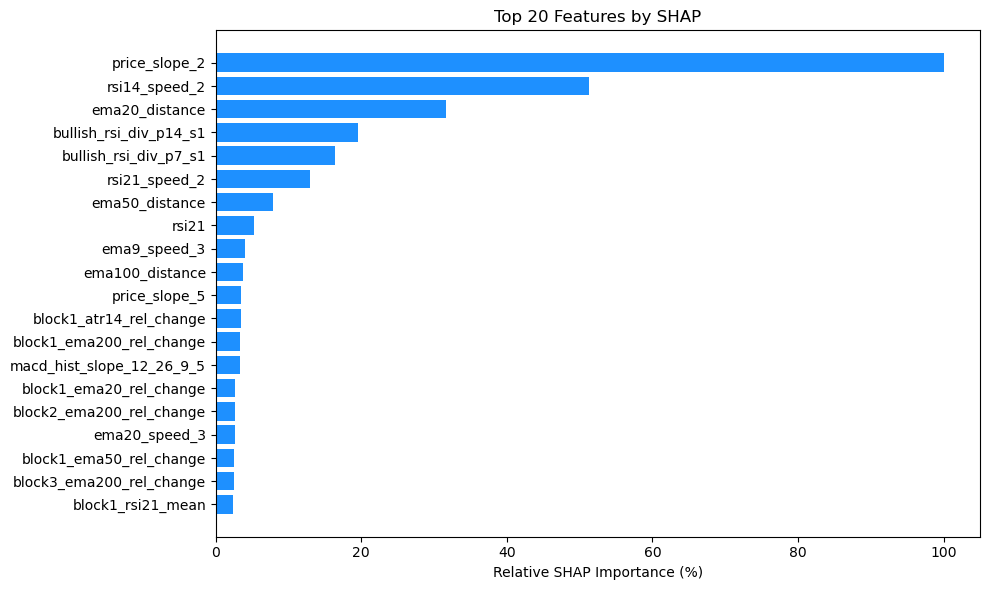


⏱ Total execution time: 0:00:13.898147
Time breakdown:
- Explainer init: 0:00:00.018281
- SHAP values: 0:00:12.939489 (93.1%)
- Analysis: 0:00:00.109597 (0.8%)


In [35]:
# Пример использования:
explain_model_shap(X_train, forest_base_line, sample_size=10000, top_n=20);

## Permutation Importance (Перестановочная важность)

**Permutation Importance** – это метод оценки важности признаков, основанный на ухудшении качества модели при случайном перемешивании значений признака.\
Если после перемешивания метрика модели значительно падает, признак считается важным.

**explain_model_permutation** Оценивает важность признаков с помощью Permutation Importance

Вход:
- X: DataFrame с признаками
- y: целевая переменная
- model: обученная модель (RandomForest, XGBoost и др.)
- scoring: метрика оценки ('f1', 'accuracy', 'roc_auc')
- n_repeats: количество повторов для стабильности
- top_n: количество топ-признаков для отображения
- random_state: seed для воспроизводимости
- n_jobs: количество ядер для параллельных вычислений

Выход:
- DataFrame с важностью признаков (Feature, Mean Importance, Std, Significant, Rank)
- Визуализация топ-признаков с доверительными интервалами

ℹ️ Model type: RandomForestClassifier
ℹ️ Scoring metric: precision
🔄 Calculating permutation importance...
✅ Completed in 0:12:55.602225

🔍 Top Features by Permutation Importance:
|   Rank | Feature                 |   Mean Importance |   Std | Significant   |
|-------:|:------------------------|------------------:|------:|:--------------|
|      1 | ema20_distance          |             0.024 | 0.000 | True          |
|      2 | price_slope_2           |             0.018 | 0.000 | True          |
|      3 | rsi14_speed_2           |             0.004 | 0.000 | True          |
|      4 | rsi21_speed_2           |             0.002 | 0.000 | True          |
|      5 | block1_rsi21_mean       |             0.001 | 0.000 | True          |
|      6 | rsi21                   |             0.001 | 0.000 | True          |
|      7 | ema20_speed_3           |             0.001 | 0.000 | True          |
|      8 | bullish_rsi_div_p7_s1   |             0.000 | 0.000 | True          |
|      9 |

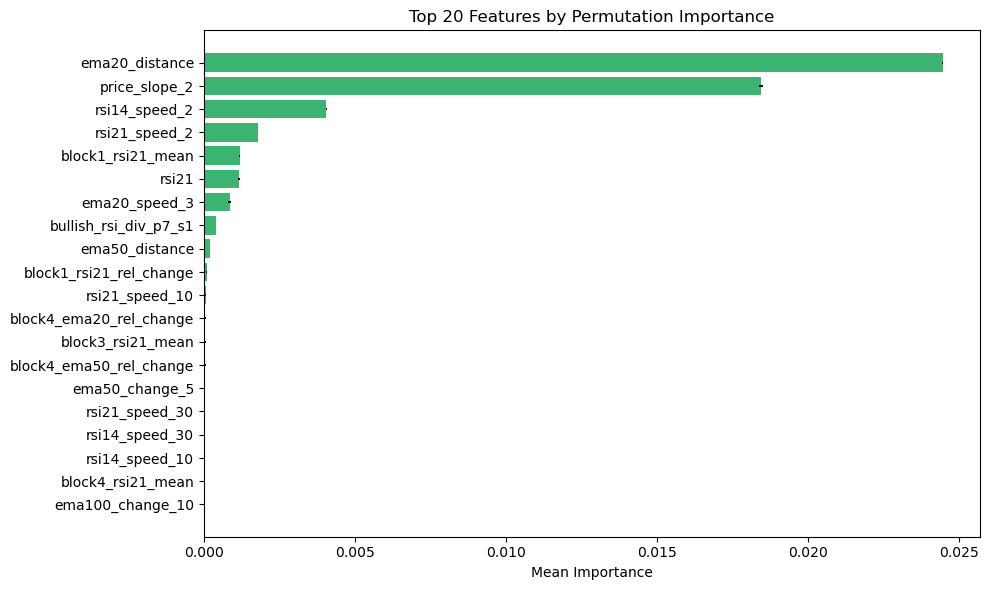

In [36]:
permutation_result = explain_model_permutation(X_train, y_train, forest_base_line, scoring='precision', n_repeats=2, top_n=20);

# 📋 14. Отбор признаков

In [104]:
top_features = ['price_slope_2',
    'rsi14_speed_2', 
    'ema20_distance',
    'bullish_rsi_div_p14_s1',
    'bullish_rsi_div_p7_s1',
    'rsi21_speed_2',
    'ema50_distance',
    'rsi21',
    'ema9_speed_3',
    'ema100_distance',
    'price_slope_5',
    'block1_atr14_rel_change',
    'block1_ema200_rel_change',
    'macd_hist_slope_12_26_9_5',
    'block1_ema20_rel_change',
    'block2_ema200_rel_change',
    'ema20_speed_3',
    'block1_ema50_rel_change',
    'block3_ema200_rel_change',
    'block1_rsi21_mean',
    'block1_rsi21_rel_change',
    'rsi21_speed_10',
    'block4_ema20_rel_change',
    'block3_rsi21_mean',
    'block4_ema50_rel_change',
    'ema50_change_5',
    'rsi21_speed_30',
    'rsi14_speed_30',
    'rsi14_speed_10',
    'block4_rsi21_mean',
    'ema100_change_10',
    'buy', 'sell','buy_strong','sell_strong', 'buy_noised', 'sell_noised', 'Date','High','Low','Close','Open', 'Volume']

In [240]:
df = df[top_features]
df_test = df_test[top_features]
df.head(3)

block1_ema20_rel_change  ema20_speed_10  block3_ema20_rel_change  \
219                 0.001493       -0.000290                 0.001484   
220                 0.001177       -0.000261                 0.001583   
221                 0.000892       -0.000221                 0.001668   

     block4_ema20_rel_change  block2_ema20_rel_change  price_slope_5  \
219                 0.000451                 0.002633       0.000213   
220                 0.000727                 0.002606       0.000496   
221                 0.001129                 0.002438       0.000595   

     block1_rsi21_mean  block1_ema50_rel_change  block4_ema50_rel_change  \
219          40.019915                 0.001094                 0.000191   
220          41.663476                 0.000980                 0.000315   
221          43.531934                 0.000871                 0.000496   

     ema20_speed_30  block2_ema50_rel_change  price_slope_10  \
219        0.000018                 0.001375       -0.000334   
220        0.000015                 0.001413        0.000042   
221        0.000009                 0.001390        0.000241   

     block3_rsi21_mean  block4_rsi21_mean  block2_rsi21_mean  \
219          43.354887          49.930226          36.200881   
220          42.559758          48.354916          35.996811   
221          41.894926          46.036496          36.409418   

     block3_ema50_rel_change  ema20_speed_60  ema50_speed_10  ema100_speed_10  \
219                 0.000724        0.000068       -0.000086         0.000008   
220                 0.000795        0.000069       -0.000083         0.000008   
221                 0.000860        0.000067       -0.000073         0.000011   

     block1_rsi21_rel_change                 Date    High     Low   Close  \
219                -0.106163  2022-03-10 00:40:00  13.984  13.981  13.984   
220                -0.170419  2022-03-10 00:41:00  14.020  13.984  14.020   
221                -0.191528  2022-03-10 00:42:00  14.025  14.016  14.016   

       Open  Volume  target  
219  13.982    28.3       0  
220  13.984    97.1       0  
221  14.020   249.4       0

# 📈 15. Сигналы модели

**plot_predict_signals** Визуализирует OHLC график с истинными и предсказанными торговыми сигналами

Аргументы:
- df с колонками: 'Open','High','Low','Close','buy','sell'
- y_pred: массив предсказаний модели (опционально)
- pred_threshold: порог бинаризации предсказаний
- start_idx: начальный индекс участка
- end_idx: конечный индекс участка

Отображает:
- Линии OHLC цен
- Истинные buy/sell сигналы (зеленые/красные маркеры)
- Предсказанные buy сигналы модели (синие маркеры)

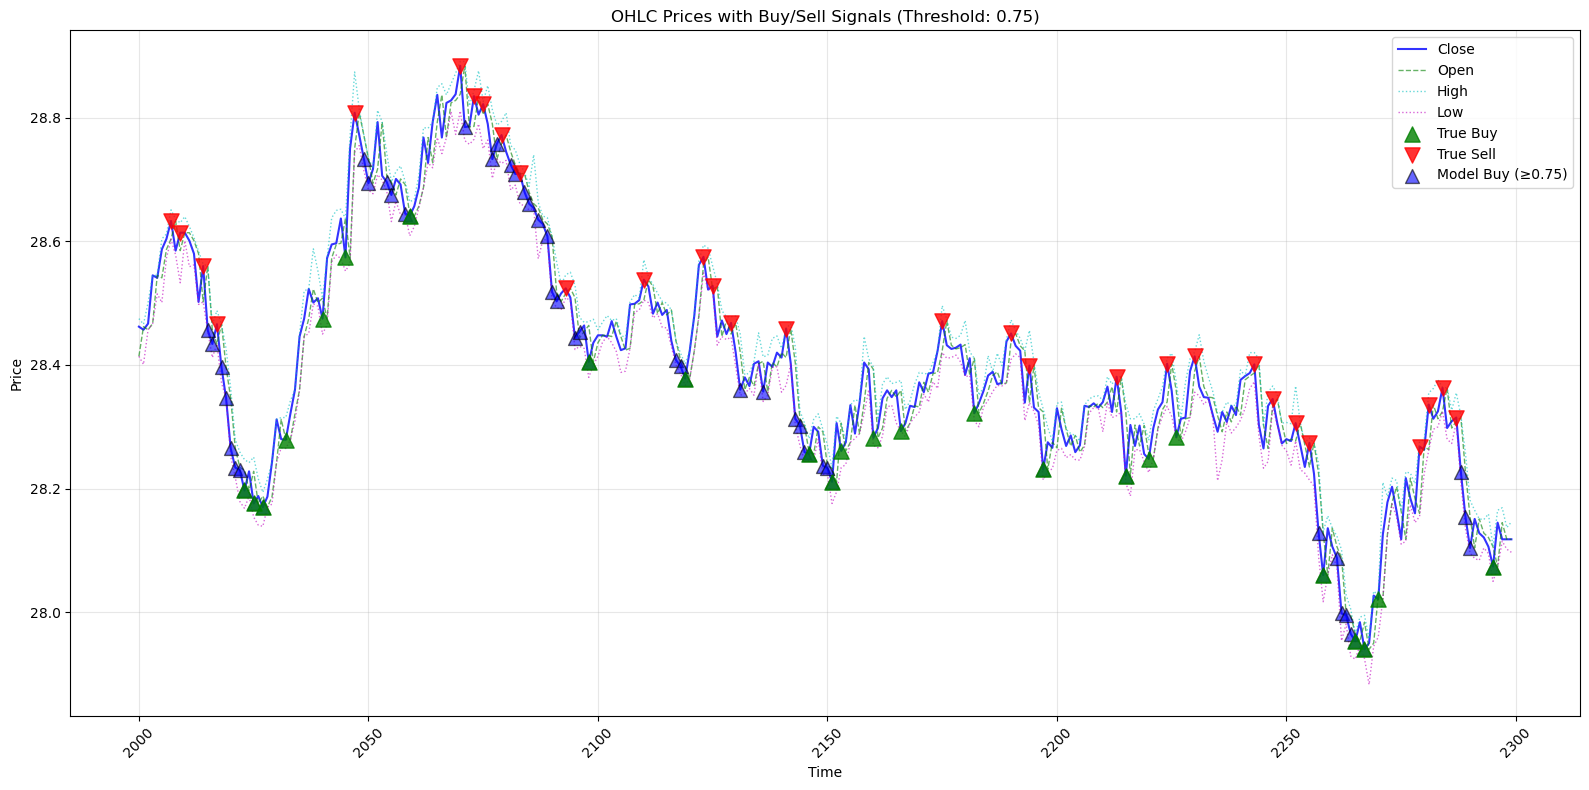

In [76]:
# Визуализация с разными порогами
y_pred_proba = forest_base_line.predict_proba(X_test)[:, 1]
plot_predict_signals(df_test, y_pred_proba, pred_threshold=0.75, start_idx=2000, end_idx=2300)

# 16. Бэктест торговой модели

**backtest_model** Проводит пошаговый бэктест торговой модели с TP/SL и анализирует результаты

Аргументы:
- df: DataFrame с признаками и ценовыми данными
- model: обученная модель машинного обучения
- X_train: тренировочные данные, для необходимых признаков
- threshold: порог для торговых сигналов
- tp_pct: уровень тейк-профита (%)
- rr: соотношение риск/прибыль
- plot: флаг отображения графиков

Возвращает:
- Общую прибыль и счетчик TP/SL сделок
- Максимальную серию убытков
- Помесячную статистику
- Таблицу всех сделок
- Графики кривой капитала и месячной прибыли

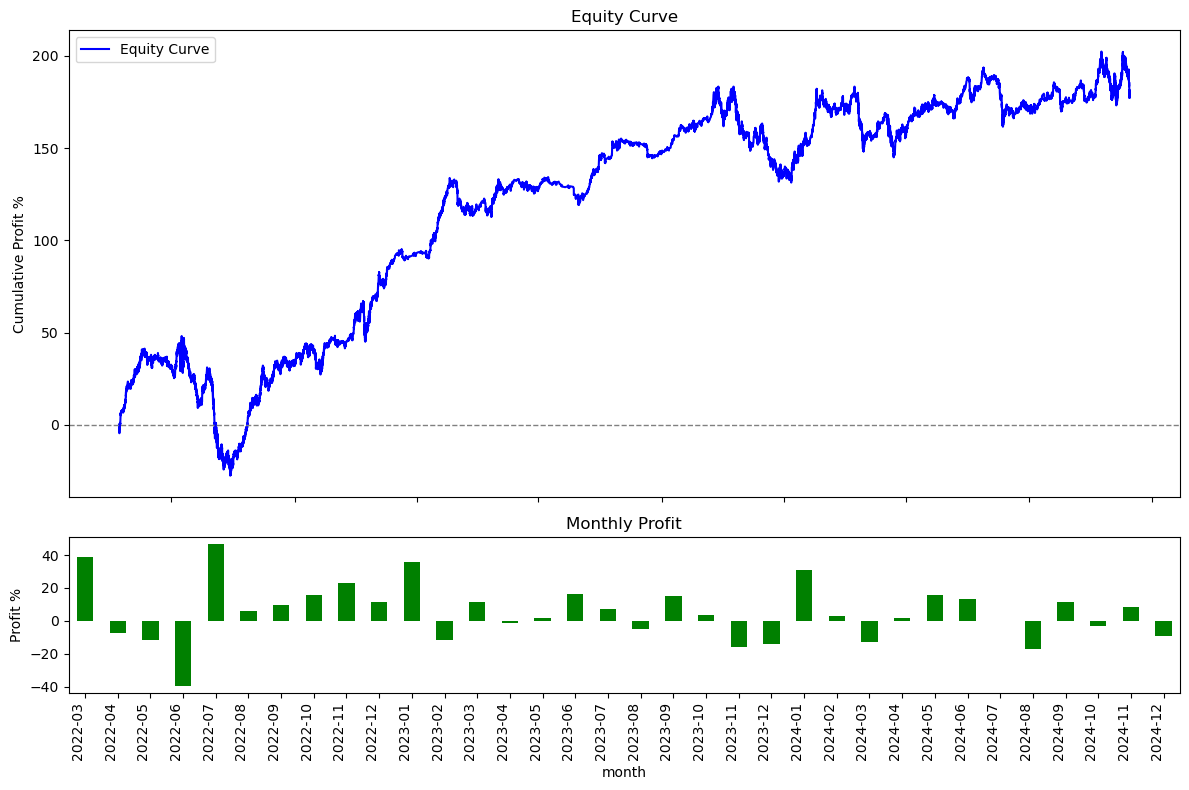

Общая прибыль: 177.33%
TP сделок: 14440, SL сделок: 21128
Макс. серия убытков: 23
month
2022-03    38.666667
2022-04    -7.333333
2022-05   -11.500000
2022-06   -39.333333
2022-07    46.666667
2022-08     6.166667
2022-09     9.666667
2022-10    15.666667
2022-11    23.166667
2022-12    11.333333
2023-01    35.833333
2023-02   -11.666667
2023-03    11.333333
2023-04    -1.500000
2023-05     1.833333
2023-06    16.500000
2023-07     7.333333
2023-08    -4.833333
2023-09    14.833333
2023-10     3.666667
2023-11   -15.833333
2023-12   -14.333333
2024-01    30.833333
2024-02     2.833333
2024-03   -13.000000
2024-04     1.500000
2024-05    15.666667
2024-06    13.166667
2024-07    -0.333333
2024-08   -16.833333
2024-09    11.333333
2024-10    -3.166667
2024-11     8.166667
2024-12    -9.166667
Freq: M, Name: profit_pct, dtype: float64


In [102]:
results = backtest_model(df=df, model=forest_base_line, X_train=X_train, threshold=0.75, tp_pct=0.005, rr=1.5, plot=True)

# Посмотрим результат
print(f"Общая прибыль: {results['total_profit']:.2f}%")
print(f"TP сделок: {results['tp_count']}, SL сделок: {results['sl_count']}")
print(f"Макс. серия убытков: {results['max_sl_streak']}")
print(results['monthly_profit'])